# Analyse de la consommation de drogue selon la personnalité et le profil des individus

lien du dataset: 

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Ce dataset est issu d'un sondage anonyme sur internet, actif entre mai 2011 et mars 2012, auquel ont participé 2018 personnes. Il fut crée par Elaine Fehrman, membre du Nottinghamshire Healthcare NHS Trust. Ce dataset fut aussi le sujet d'un papier scientifique de 2015 intitulé "The Five Factor Model of personality and evaluation of drug consumption risk"(E. Fehrman) qui proposait une analyse statistique ainsi que des modèles de machine learning pour évaluer nottamment les corrélations entre la personnalité des individus et leur propension à consommer chacune des drogues présente dans le dataset.

Le dataset contient 1885 échantillons (sur les 2018 interrogés, 166 n'ont pas répondu correctement au test), ce qui nous donne les informations suivantes pour chaque personne: 

- 5 informations personnelles: âge, genre, niveau d'éducation, pays d'origine et ethnicité

- 7 traits de personnalités: « anxiété »,  « niveau d'extraversion », « ouverture à l'expérience », « compassion » , « niveau rigueur », « impulsivité » et « recherche de sensation ». Pour chaque trait de caractère, les participants devaient effectuer un test. Ils étaient ensuite évalués sur une échelle numérique qui varie selon les tests.

- Des informations sur la date de leur dernière consommation de drogues parmis 19 drogues, dont une fictive (le Semeron) pour repérer les participants susceptibles de mentir dans leurs réponses.
Les colonnes pouvaient prendre les valeurs suivantes: 
-CL0: Never Used
-CL1: Used over a Decade
-CL2: Used in the Last Decade
-CL3: Used in the Last Year
-CL4: Used in the Last Month
-CL5: Used in the Last Week
-CL6: Used in the Last Day


Nous proposons d'utiliser ces données pour créer un algorithme de machine learning capable de prédire en fonction de la personnalité et des informations personnelles de chaque individus leur propension à consommer régulièrement des drogues illégales (nous expliquerons plus bas pourquoi nous ne prenons pas non plus en compte le cannabis). Nous formulerons ce problème sous forme de classification binaire. Nous allons créer notre target en regroupant dans une catégorie 'utilisateur' les personnes ayant consommé une des drogues (sauf le Semeron, le cannabis, la nicotine, le chocolat et la caféine) il y a moins d'une semaine et dans "non-utilisateur", les autres.

Nous allons considérer que nous travaillons pour une association ou un organisme d'assistance social qui souhaite anticiper si une personne a plus ou moins de chance de devenir consommateur régulier de drogue. Nous allons résoudre ce problème en développant un modèle de prédiction. 



## Importations et aperçu géneral des données

Nous allons importer les datas et visualiser des informations très générales sur le dataset.

### Importation des frameworks

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 796 kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu, norm, normaltest, shapiro, anderson
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from  sklearn.preprocessing import OrdinalEncoder as skOrdinalEncoder
#from category_encoders import OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,plot_confusion_matrix,precision_score,precision_recall_fscore_support,plot_precision_recall_curve,roc_curve,roc_auc_score,recall_score,f1_score,make_scorer,SCORERS,plot_roc_curve,roc_curve,precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier


### Importation des données

Nous devons ajouter manuellement le  nom des colonnes à notre dataset (en se basant sur les métadatas) étant donné que le fichier .data fourni ne les inclut pas.

In [3]:
perso=    ['Age',
          'Gender',
          'Education',
          'Country',
          'Ethnicity']

personality = [
    'Neuroticism',
    'Extraversion',
    'Openness to experience',
    'Agreeableness',
    'Conscientiousness',
    'Impulsiveness',
    'Sensation seeking'
]

drugs = [
          "alcohol",
          "amphetamines",
          "amyl nitrite",
          "benzodiazepine",
          "caffeine",
          "cannabis",
          "chocolate",
          "cocaine",
          "crack",
          "ecstasy",
          "heroin",
          "ketamine",
          "legal highs",
          "LSD",
          "methadone",
          "mushrooms",
          "nicotine",
          "fictious drug (Semeron)",
          "volatile substance abuse"       
          ]

all_columns= perso+personality+drugs

In [16]:
df=pd.read_csv("drug_consumption.data",names=all_columns).reset_index(drop=True)
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,...,ecstasy,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,fictious drug (Semeron),volatile substance abuse
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


### shape

In [ ]:
df.shape

(1885, 31)

### types des données

In [17]:
df.dtypes

Age                         float64
Gender                      float64
Education                   float64
Country                     float64
Ethnicity                   float64
Neuroticism                 float64
Extraversion                float64
Openness to experience      float64
Agreeableness               float64
Conscientiousness           float64
Impulsiveness               float64
Sensation seeking           float64
alcohol                      object
amphetamines                 object
amyl nitrite                 object
benzodiazepine               object
caffeine                     object
cannabis                     object
chocolate                    object
cocaine                      object
crack                        object
ecstasy                      object
heroin                       object
ketamine                     object
legal highs                  object
LSD                          object
methadone                    object
mushrooms                   

### présence de données dupliquées?

In [ ]:
df[df.duplicated()]

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,...,ecstasy,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,fictious drug (Semeron),volatile substance abuse


aucune donnée dupliqué

### Détection des nans

In [ ]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Age                         0.0
nicotine                    0.0
mushrooms                   0.0
methadone                   0.0
LSD                         0.0
legal highs                 0.0
ketamine                    0.0
heroin                      0.0
ecstasy                     0.0
crack                       0.0
cocaine                     0.0
chocolate                   0.0
cannabis                    0.0
caffeine                    0.0
fictious drug (Semeron)     0.0
benzodiazepine              0.0
amphetamines                0.0
alcohol                     0.0
Sensation seeking           0.0
Impulsiveness               0.0
Conscientiousness           0.0
Agreeableness               0.0
Openness to experience      0.0
Extraversion                0.0
Neuroticism                 0.0
Ethnicity                   0.0
Country                     0.0
Education                   0.0
Gender                      0.0
amyl nitrite                0.0
volatile substance abuse    0.0
dtype: f

Le dataset ne contient aucun nan.

### Pré-processing avant l'analyse


Les colonnes sur les infos personnelles et les tests de personnalité sont déjà encodées et normalisées. Pour faire une analyse des données avec des valeurs compréhensibles,  nous allons retransformer ces données.

Nous allons enlever les personnes ayant indiqué qu'elles avaient consommé du Semeron en considérant qu'ils ne sont pas fiables.

In [5]:
df["fictious drug (Semeron)"].value_counts()#8 personnes ont menti

CL0    1877
CL2       3
CL3       2
CL1       2
CL4       1
Name: fictious drug (Semeron), dtype: int64

In [6]:
drugs.remove("fictious drug (Semeron)")
df=df.drop("fictious drug (Semeron)",axis=1);

for i in drugs:
    df[i] = df[i].map({'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6})
    df[i] = df[i].apply(lambda x: int(x))

df_analyse=df.copy()

df_analyse["Age"]=df_analyse["Age"].map({-0.95197:'18-24',
               -0.07854:'25-34',
               0.49788:'35-44',
               1.09449:'45-54',
               1.82213:'55-64',
               2.59171:"65+"})


df_analyse["Gender"]=df_analyse["Gender"].map({0.48246: "Female",
                                              -0.48246: "Male"})


df_analyse["Education"]=df_analyse["Education"].map({-2.43591: "Left school before 16 years",
                                                     -1.73790:"Left school at 16 years",
                                                     -1.43719: "Left school at 17 years",
                                                     -1.22751:"Left school at 18 years",
                                                     -0.61113: "Some college or university, no certificate or degree",
                                                     -0.05921: "Professional certificate/ diploma",
                                                     0.45468: "University degree",
                                                     1.16365: "Masters degree", 
                                                     1.98437: "Doctorate degree"  })

df_analyse["Country"]=df_analyse["Country"].map({-0.09765: "Australia",
                                                 0.24923: "Canada",
                                                 -0.46841: "New Zealand",
                                                 -0.28519: "Other",
                                                 0.21128: "Republic of Ireland",
                                                 0.96082:"UK",
                                                 -0.57009: "USA" })

df_analyse["Ethnicity"]=df_analyse["Ethnicity"].map({-0.50212: "Asian",
                                                     -1.10702: "Black",
                                                     1.90725: "Mixed-Black/Asian",
                                                     0.12600: "Mixed-White/Asian",
                                                     -0.22166: "Mixed-White/Black",
                                                     0.11440: "Other",
                                                     -0.31685: "White"})



df_analyse.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,...,crack,ecstasy,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,volatile substance abuse
0,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,2,0
1,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,4,0,2,0,2,3,0,4,0
2,35-44,Male,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,1,0,0
3,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,2,0,0,0,0,2,0
4,35-44,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,1,0,0,1,0,0,2,2,0


## Analyse univariée, distribution des données sur chaque colonne

Dans cette partie, nous allons explorer chacunes des colonnes du dataset individuellement pour avoir une bonne idée des valeurs qu'elles peuvent prendre et leur distribution. 

Notons que les chercheurs ayant travaillé sur les données ont indiqué que la population échantillonée est non-représentative de la population globale et que la proportion de consommateurs de drogues illicites est plus élevée ici que dans la réalité.

### Distribution des données sur les informations personnelles

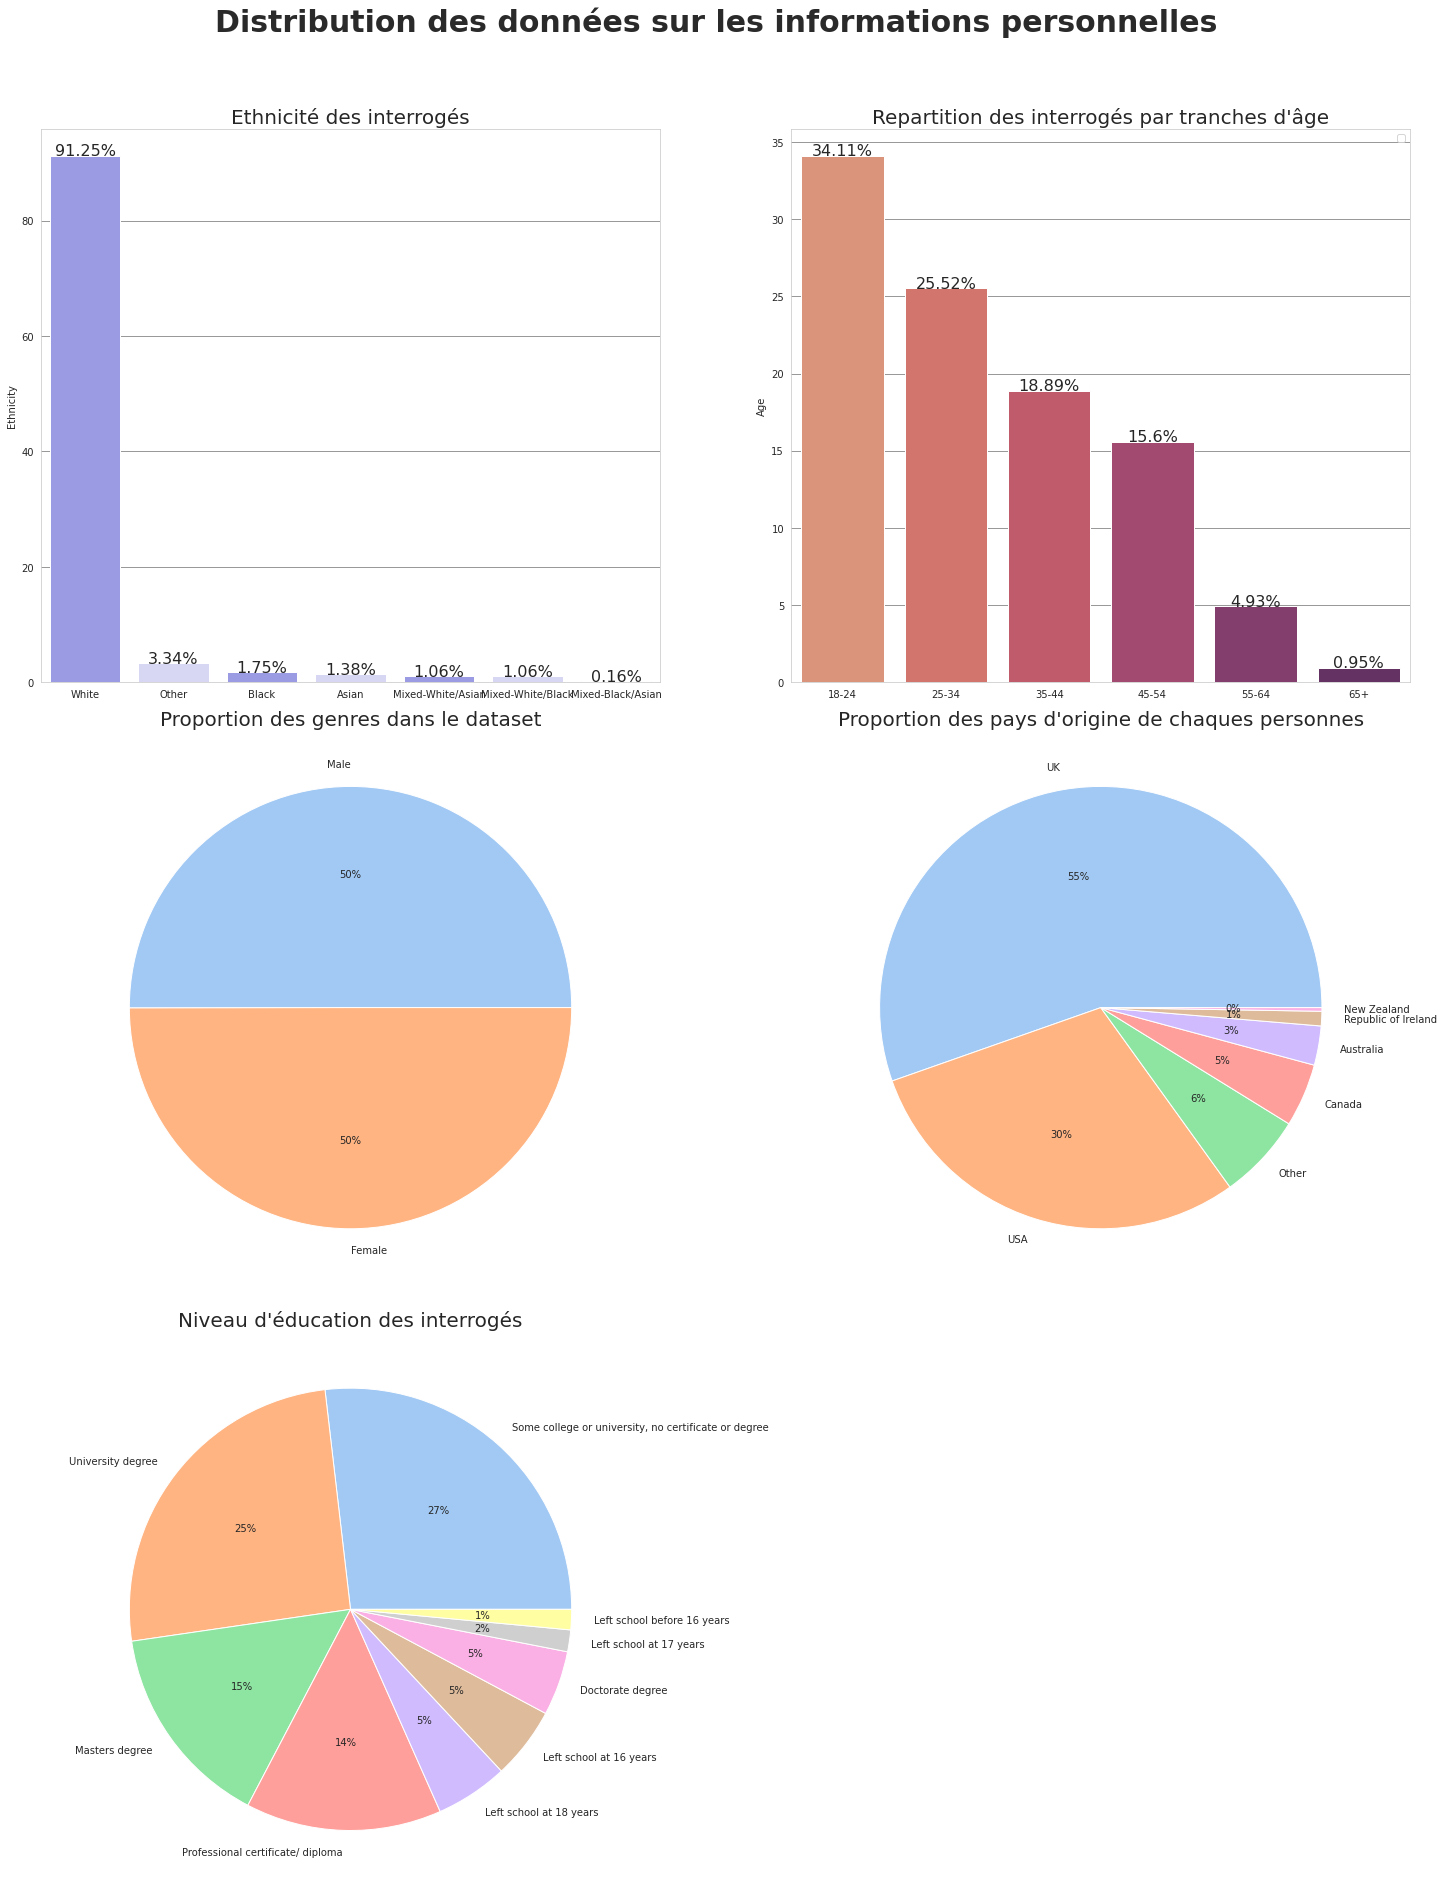

In [ ]:
fig,ax=plt.subplots(nrows=3, ncols=2,figsize=[20,25])
plt.suptitle('Distribution des données sur les informations personnelles',fontsize=30, x=0.5, y=1.05, weight = 'bold',c="#2A2A2A")


sns.barplot(x=df_analyse["Ethnicity"].value_counts().index,y=df_analyse["Ethnicity"].value_counts()*100/len(df_analyse),ax=ax[0,0],palette=["#8F8FEF","#D2D2F9"])
ax[0,0].set_title("Ethnicité des interrogés",fontsize=20)
ax[0,0].yaxis.grid(color='gray')
ax[0,0].set_axisbelow(True)
for p in ax[0,0].patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = (2*p.get_x()+p.get_width())/2
      txt_y = p.get_height()
      ax[0,0].text(txt_x,txt_y,txt,size=16,ha='center')

sns.barplot(x=df_analyse["Age"].value_counts().index,y=df_analyse["Age"].value_counts()*100/len(df_analyse),ax=ax[0,1],palette=sns.color_palette("flare"))
ax[0,1].legend()
ax[0,1].set_title("Repartition des interrogés par tranches d'âge",fontsize=20)
ax[0,1].yaxis.grid(color='gray')
ax[0,1].set_axisbelow(True)
for p in ax[0,1].patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = (2*p.get_x()+p.get_width())/2
      txt_y = p.get_height()
      ax[0,1].text(txt_x,txt_y,txt,size=16,ha='center')

ax[1,0].pie(df_analyse["Gender"].value_counts(),labels=df_analyse["Gender"].value_counts().index,colors=sns.color_palette('pastel'),autopct='%.0f%%')
ax[1,0].set_title("Proportion des genres dans le dataset",fontsize=20)

ax[1,1].pie(df_analyse["Country"].value_counts(),labels=df_analyse["Country"].value_counts().index,colors=sns.color_palette('pastel'),autopct='%.0f%%')
ax[1,1].set_title("Proportion des pays d'origine de chaques personnes",fontsize=20)

ax[2,0].pie(df_analyse["Education"].value_counts(),labels=df_analyse["Education"].value_counts().index,colors=sns.color_palette('pastel'),autopct='%.0f%%')
ax[2,0].set_title("Niveau d'éducation des interrogés",fontsize=20)

ax[2,1].axis("off")
plt.tight_layout()

- **Ethnicité**: La grande majorité des personnes interrogées ont répondu qu'elles étaient blanches. Les données à ce niveau ne sont pas représentative de la population des pays dont elles viennent.
- **Age**: Les interrogés sont répartis par tranche d'âge. La majorité d'entre eux est jeune avec une décroissance linéaire du nombre de personnes sur les tranches d'âges plus élevées.
- **Genre**: Egalité quasi-parfaite entre les hommes et les femmes
- **Pays d'origine**: La grande majorité des interrogés viennent de pays anglo-saxons notamment le Royaume-Uni et les Etats-unis. La catégorie "Autre" regroupe l'ensemble des pays non anglo-saxons. 
- **Niveau d'éducation**: La majorité des personnes ont un niveau de diplôme d'étude supérieur en dessous du doctorat.


### Analyse des mesures sur les traits de personnalité


Nous n'avons pas dénormalisé les scores des tests de personnalité pour des raisons pratique. De toutes façons, on ne perd pas d'information sur la distribution des scores pour chaque test.

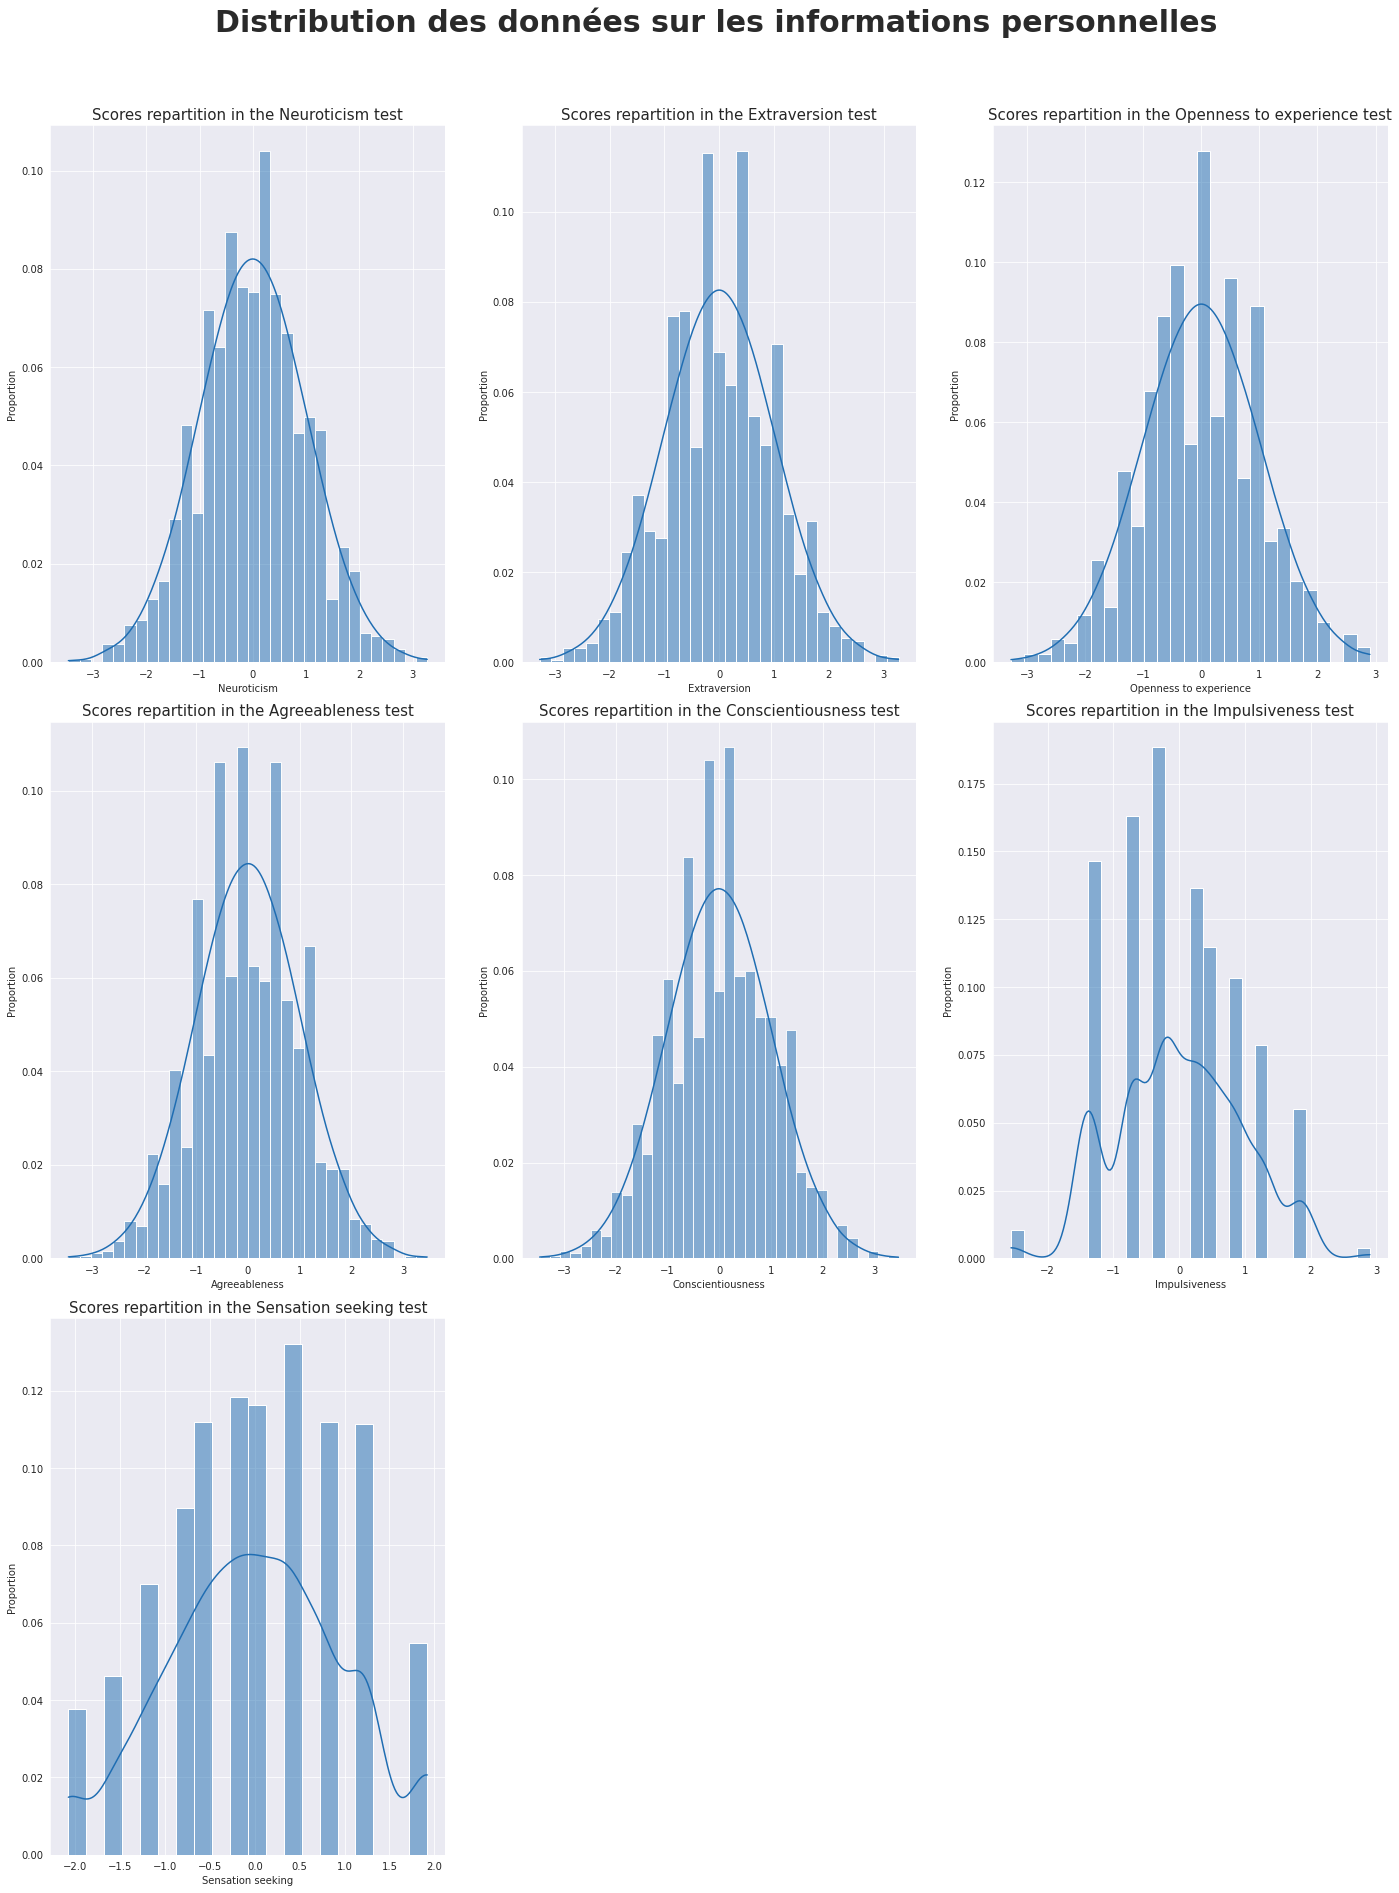

In [ ]:
sns.set_style("darkgrid")
fig,ax=plt.subplots(nrows=3, ncols=3,figsize=[20,25])
plt.suptitle('Distribution des données sur les informations personnelles',fontsize=30, x=0.5, y=1.05, weight = 'bold',c="#2A2A2A")
for col,i in zip(personality,range(7)):
  sns.histplot(x=df_analyse[col], kde=True,ax=ax[i//3,i%3],color="#1F6DB2",stat="proportion")
  ax[i//3,i%3].set_title(f"Scores repartition in the {col} test",fontsize=15)

ax[2,1].axis("off")
ax[2,2].axis("off")
plt.tight_layout()

On peut voir que toutes les courbes dessinent une courbe proche d'une courbe en cloche. On ne distingue pas d'anomalies dans ces données.

### Distribution des données sur la consommation de chaque drogue 

In [ ]:
df_analyse.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,...,crack,ecstasy,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,volatile substance abuse
0,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,2,0
1,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,4,0,2,0,2,3,0,4,0
2,35-44,Male,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,1,0,0
3,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,2,0,0,0,0,2,0
4,35-44,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,1,0,0,1,0,0,2,2,0


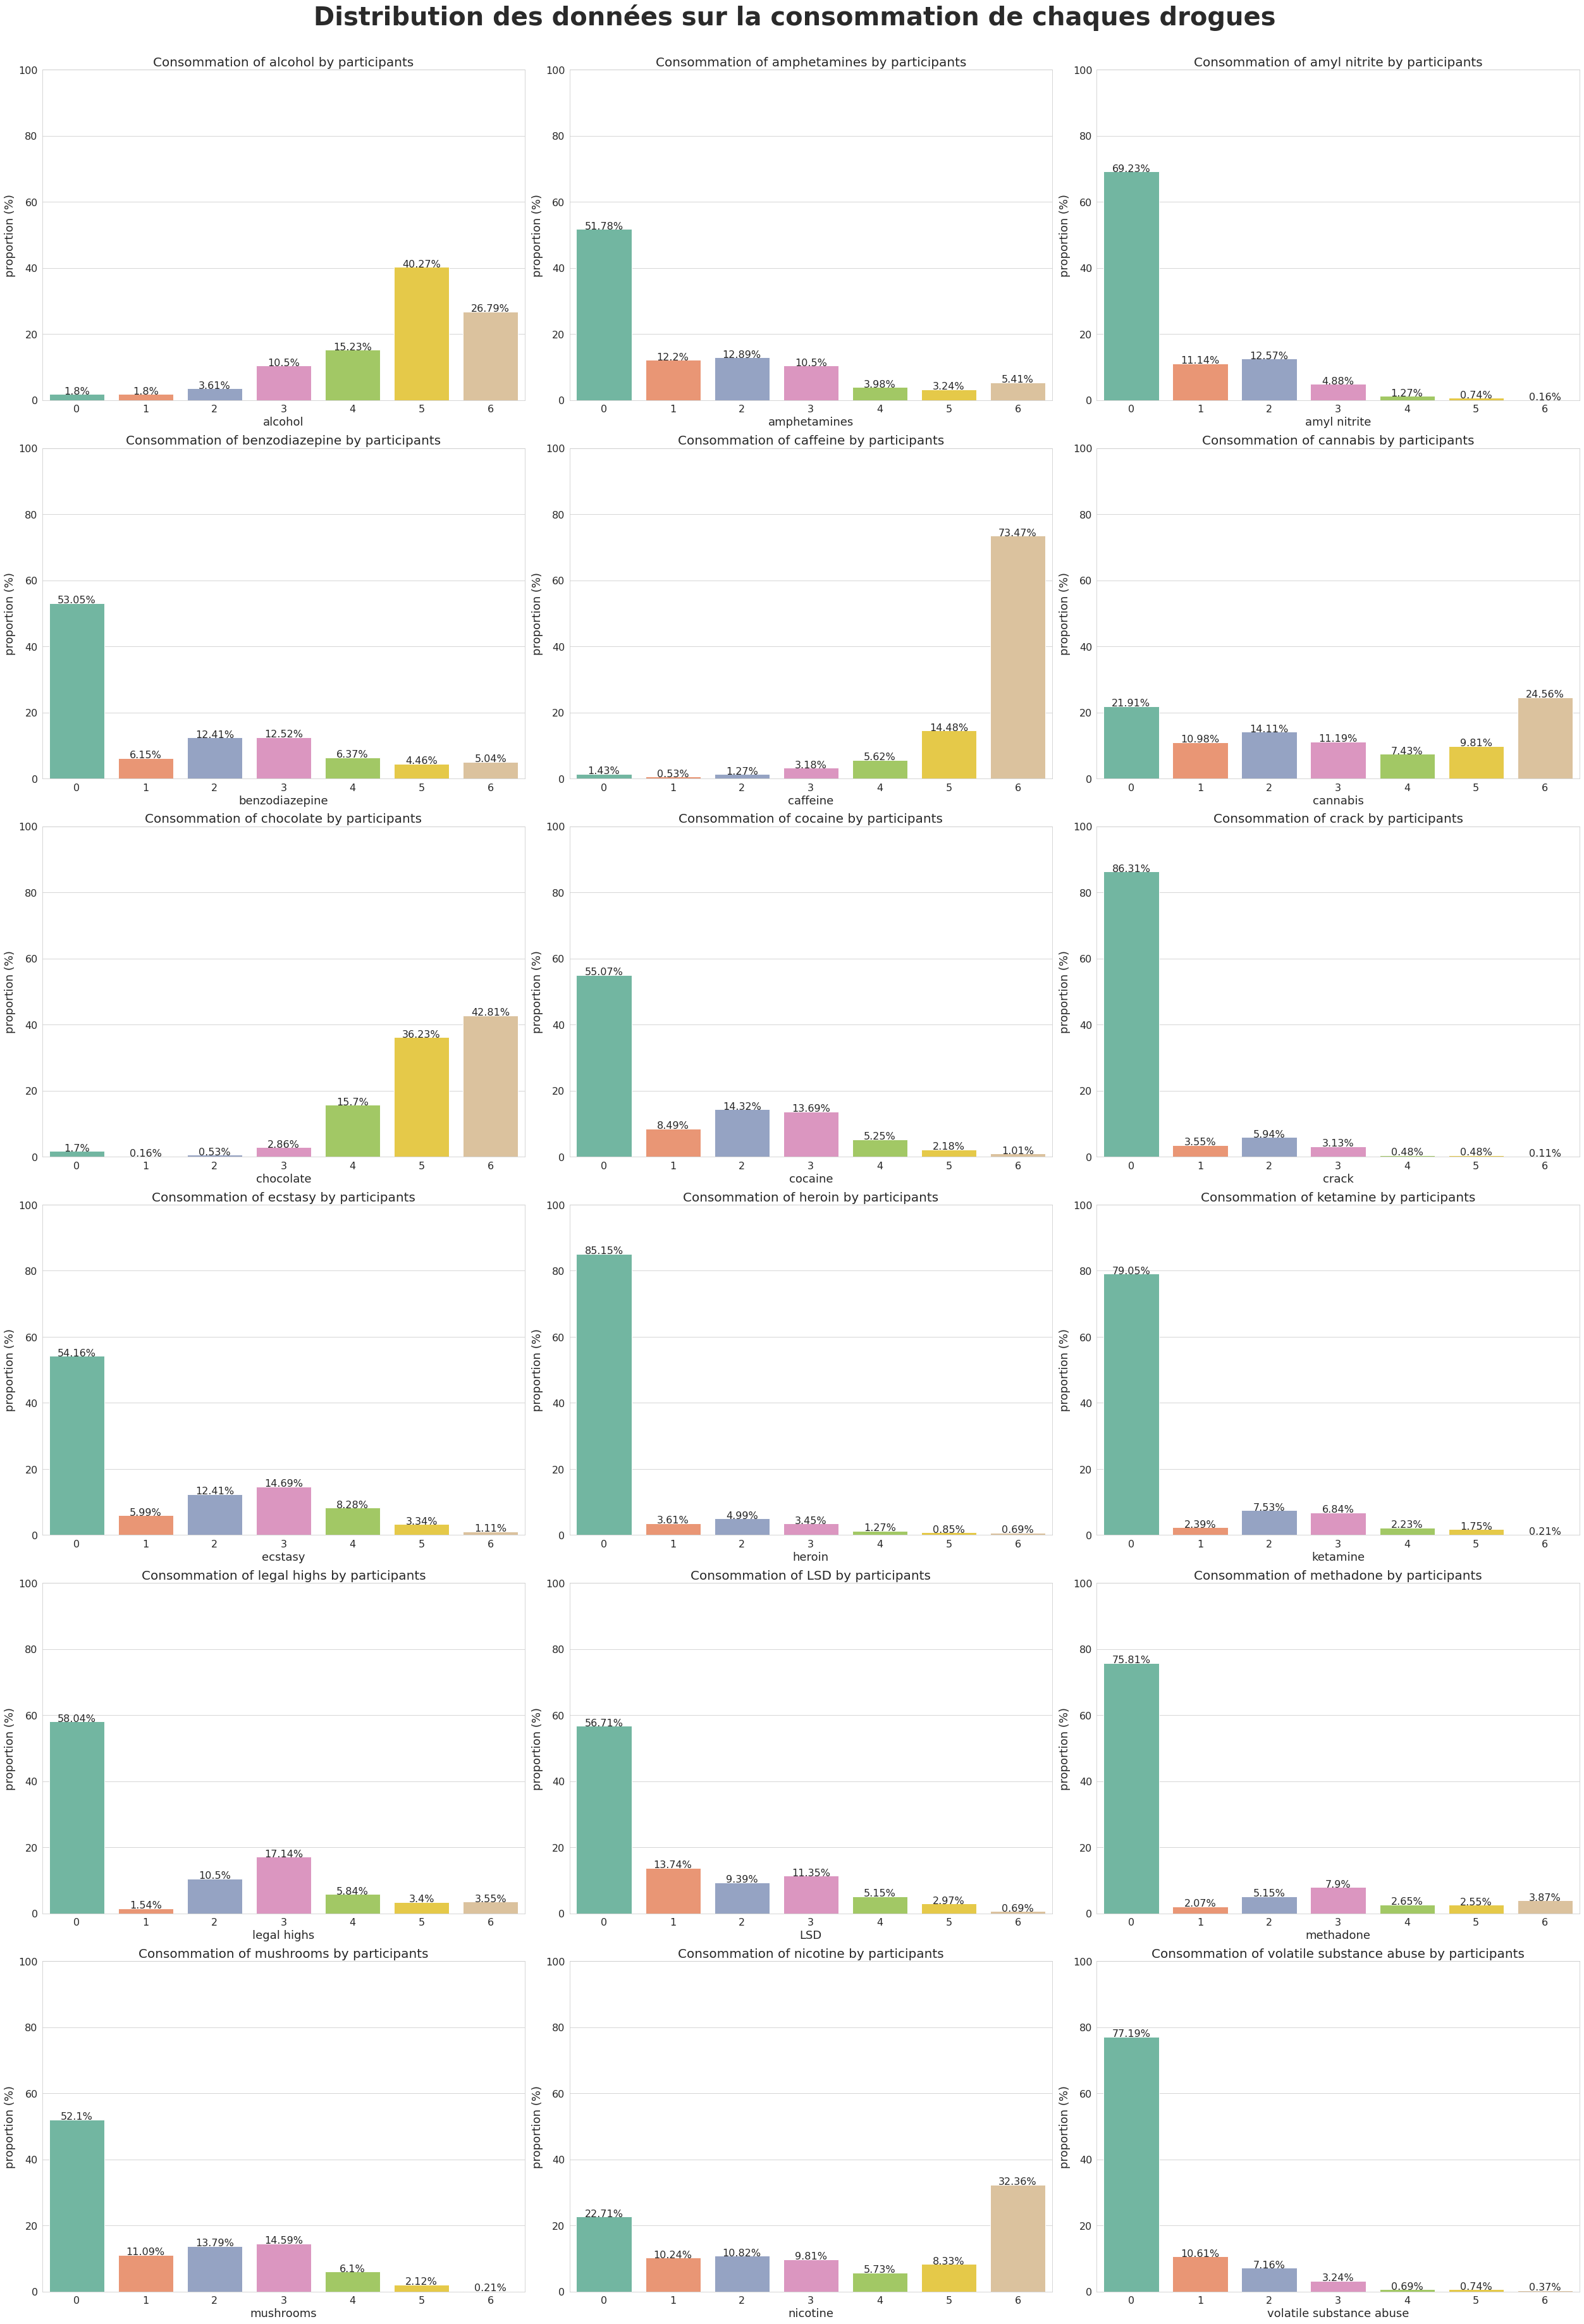

In [ ]:
sns.set_style("whitegrid")
fig,ax=plt.subplots(nrows=6, ncols=3,figsize=[35,50])
plt.suptitle('Distribution des données sur la consommation de chaques drogues',fontsize=40, x=0.5, y=1.02, weight = 'bold',c="#2A2A2A")
for col,i in zip(drugs,range(19)):
  sns.barplot(x=df_analyse[col].value_counts().index,y=df_analyse[col].value_counts()*100/len(df_analyse),ax=ax[i//3,i%3],palette=sns.color_palette("Set2"),order=[0,1,2,3,4,5,6])
  ax[i//3,i%3].set_title(f"Consommation of {col} by participants",fontsize=20)
  ax[i//3,i%3].tick_params(labelsize=16)
  ax[i//3,i%3].set_xlabel(f"{col}",fontsize=18)
  ax[i//3,i%3].set_ylabel("proportion (%)",fontsize=18)
  ax[i//3,i%3].set_ylim(0,100)

  for p in ax[i//3,i%3].patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = (2*p.get_x()+p.get_width())/2
      txt_y = p.get_height()
      ax[i//3,i%3].text(txt_x,txt_y,txt,size=16,ha='center')
 
plt.tight_layout()
plt.savefig('Distribution des données 3.png', bbox_inches='tight')

Les drogues les plus utilisées sont celles qui sont légales (chocolat, caféine, nicotine et alcools). Mais on remarque aussi une consommation très elevée de cannabis (illégal dans la plupart des pays anglo-saxons et dans la majorité des états américains). Les autres drogues n'ont jamais été utilisées par la plupart des participants, ou il y a longtemps.

A noter que la drogue "legal highs" n'est en fait pas légale.




## Analyse bivariée entre données et target et corrélations

Dans cette partie, nous allons compléter notre analyse univariée en comparant les variables avec l'ensemble des colonnes drogues (que nous regrouperons ensuite pour créer notre target) et en établissant des corrélations, ce qui nous permettera de tirer des conclusions sur les modifications à apporter sur le dataset avant de créer notre modèle.

### Heatmaps

Regardons la distribution de chaque groupe de colonnes sur les informations personnelles avec la consommation de chaque drogue.

Pour les heatmaps, nous allons compter uniquement les personnes ayant consommé de la drogue il y a moins d'une semaine, puisque ce sont ces personne que nous inclurons dans notre target.

In [ ]:
#Fonction heatmap

def heatmap(dataset, analyse_column, columns, method = 'heatmap', cmap = "coolwarm"):

  fig, ax = plt.subplots(figsize = [25,12])

  analyse = sorted(list(dataset[f'{analyse_column}'].unique()), key = str)    

  matrix = [[0]*len(columns) for i in range(len(analyse))]
  heatmap = np.array(matrix)

  for i in range(dataset.shape[0]):
    for k, obj in enumerate(columns):
      # 12 is first instance of drug in columns
      # this test is if columns = drugs
      if df_analyse.iloc[i, k+12] in [5,6]:
        heatmap[analyse.index(dataset.iloc[i,list(dataset.columns).index(f'{analyse_column}')]), k] += 1

  if method == 'barplot' : 
    matrix= []
    for i in range(heatmap.shape[1]):
        for j in range(heatmap.shape[0]):
          line = [columns[i], heatmap[j,i], analyse[j]]
          matrix.append(line)
    dataframe = pd.DataFrame(matrix, columns = ['x', 'y', f"{analyse_column}"])
    sns.barplot(data = dataframe, x = 'x', y = 'y', hue = analyse_column)
  if method == 'heatmap' : 
    ax =sns.heatmap(heatmap, cmap = cmap, linewidths = 0.5, annot= True, annot_kws = {'size':10}, square = True, fmt = 'g')
    ax.set_yticklabels(analyse, rotation = 0)
  ax.set_xticklabels(columns, rotation = 90)


Text(0.5, 0.95, "Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon les tranches d'âges")

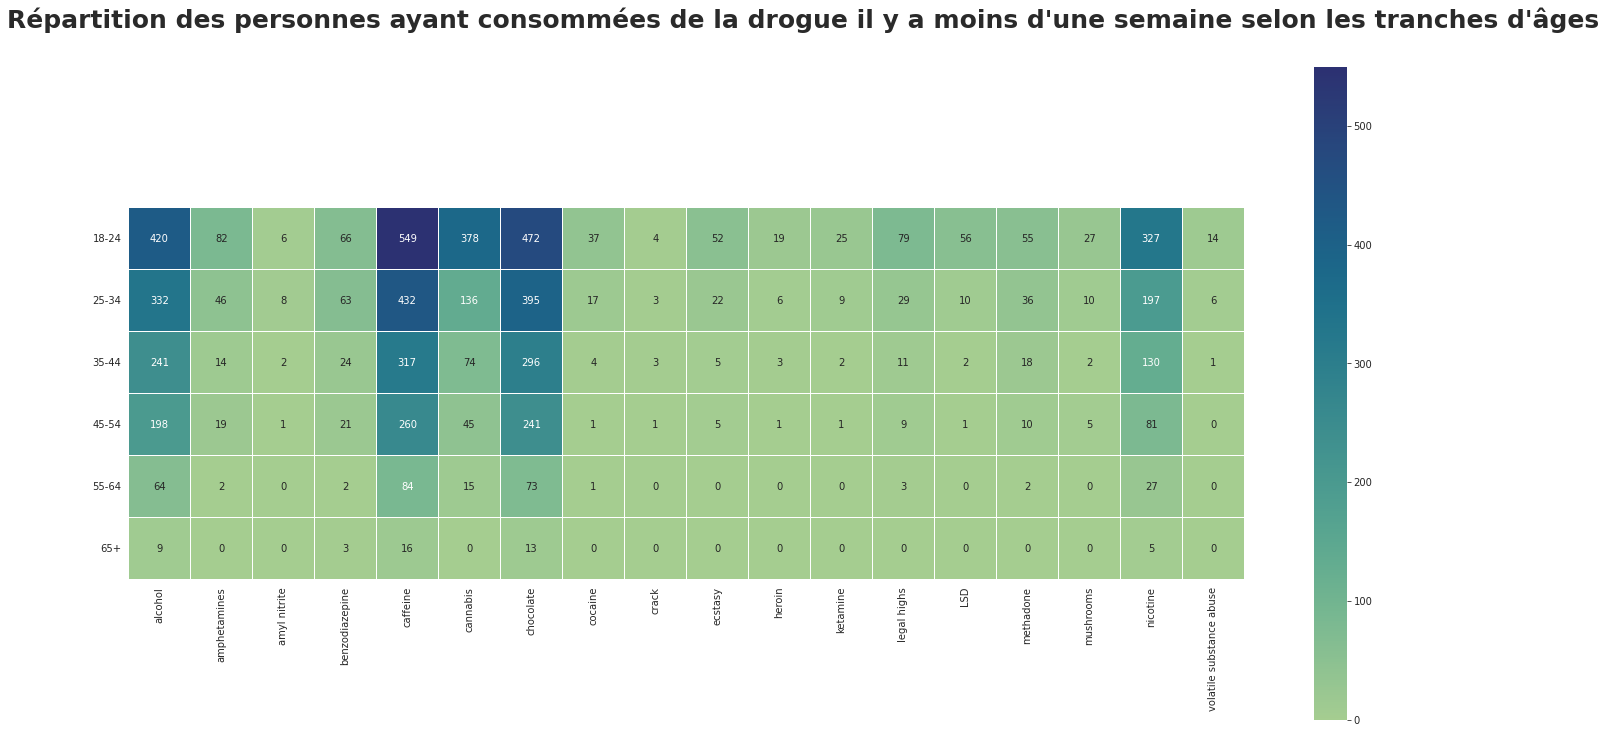

In [ ]:
heatmap(df_analyse, 'Age', drugs, cmap = "crest")
plt.suptitle("Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon les tranches d'âges",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

La heatmap ci-dessus est en accord avec les premières observations de l'analyse univariée (sur-représentation des "jeunes" dans le dataset). Même en prenant en compte ce biais dans les données, on ne distingue pas de changement de tendance quand on "descend" dans la heatmap. 

Text(0.5, 0.95, "Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon les pays")

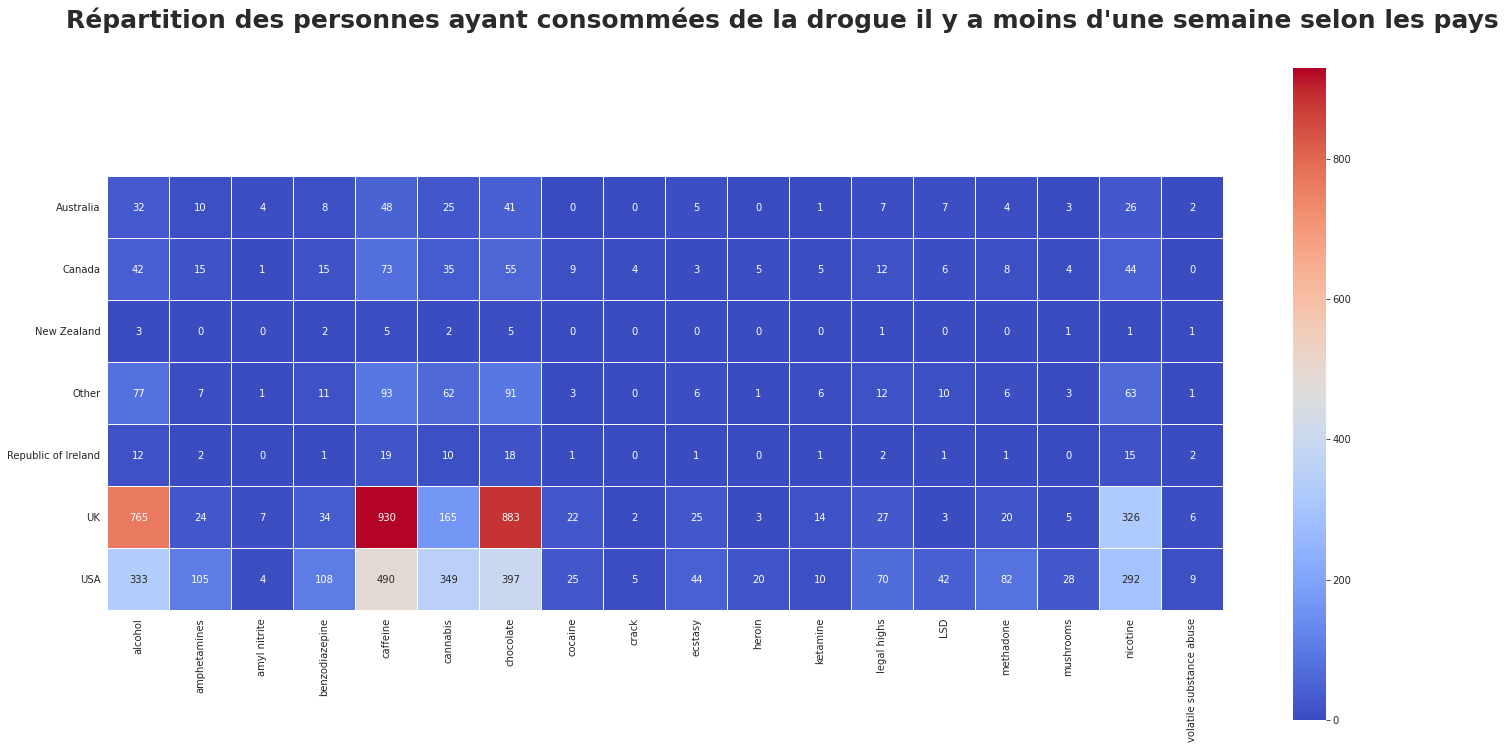

In [ ]:
heatmap(df_analyse, 'Country', drugs)
plt.suptitle("Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon les pays",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

Encore une fois, la tendance correspond aux premières observations: les USA et le Royaume-Uni sont sur-représentés. On constate tout de même que le canabis est particulièrment consommé aux Etats-Unis même si le pays ne represente que 30% des données (le cannabis est légal dans certains états).

Text(0.5, 0.95, "Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon le niveau d'éducation")

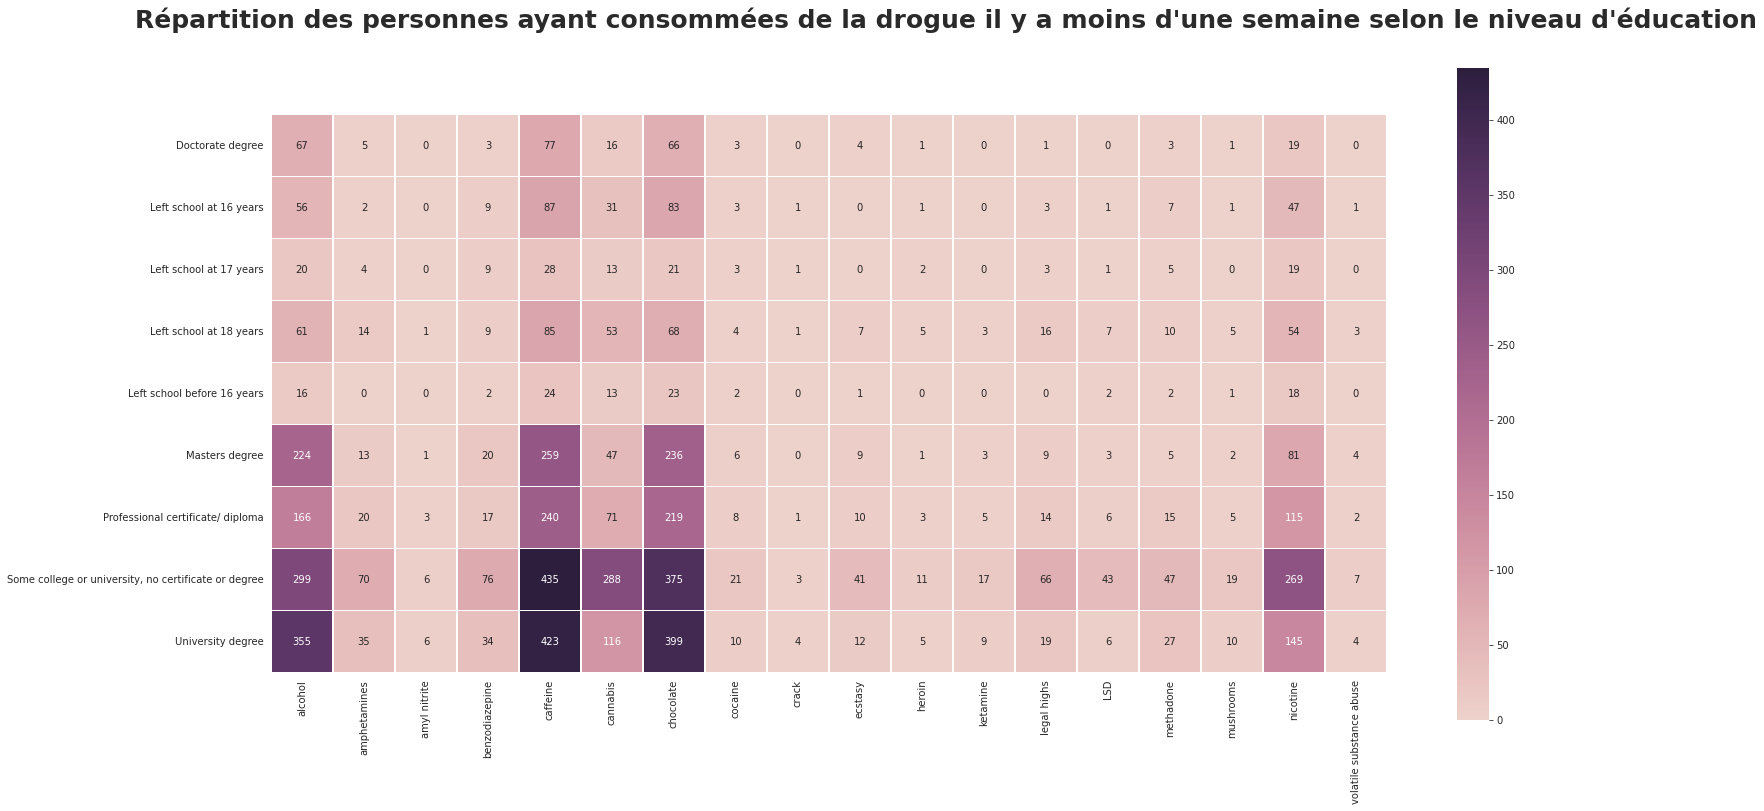

In [ ]:
heatmap(df_analyse, 'Education', drugs,cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle("Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon le niveau d'éducation",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

Text(0.5, 0.95, "Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon le genre")

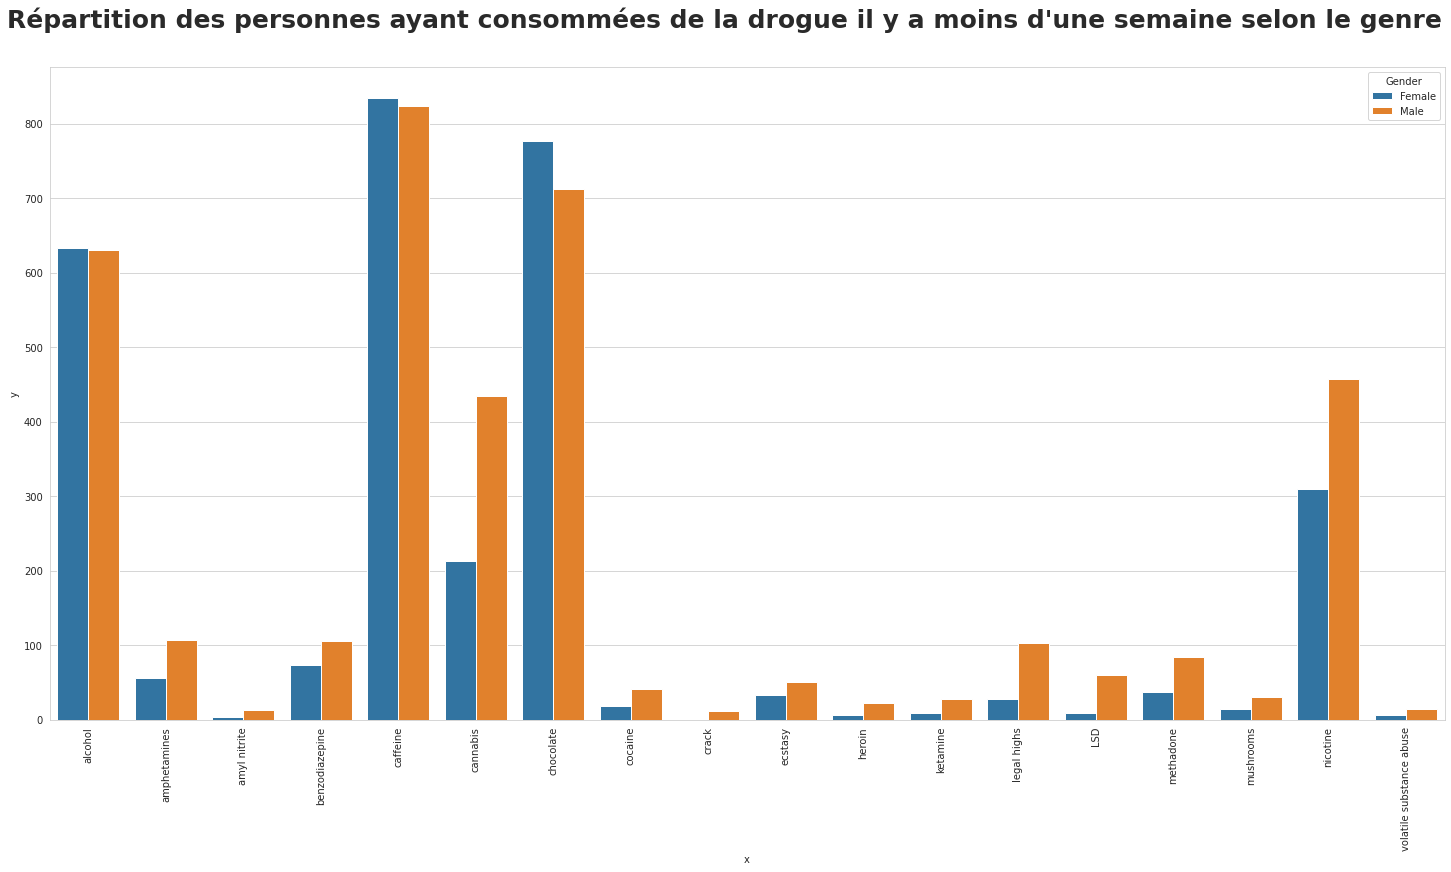

In [ ]:
heatmap(df_analyse, 'Gender', drugs, cmap=None, method = 'barplot')
plt.suptitle("Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon le genre",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

La répartiton des hommes et des femmes est quasiment équivalente dans le dataset, mais on constate que les hommes sont nettement plus nombreux à avoir consommé des drogues illégales il y a moins d'une semaine que les femmes. Le genre semble être un critère discriminant important pour notre analyse.

Text(0.5, 0.95, "Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon l'ethnie")

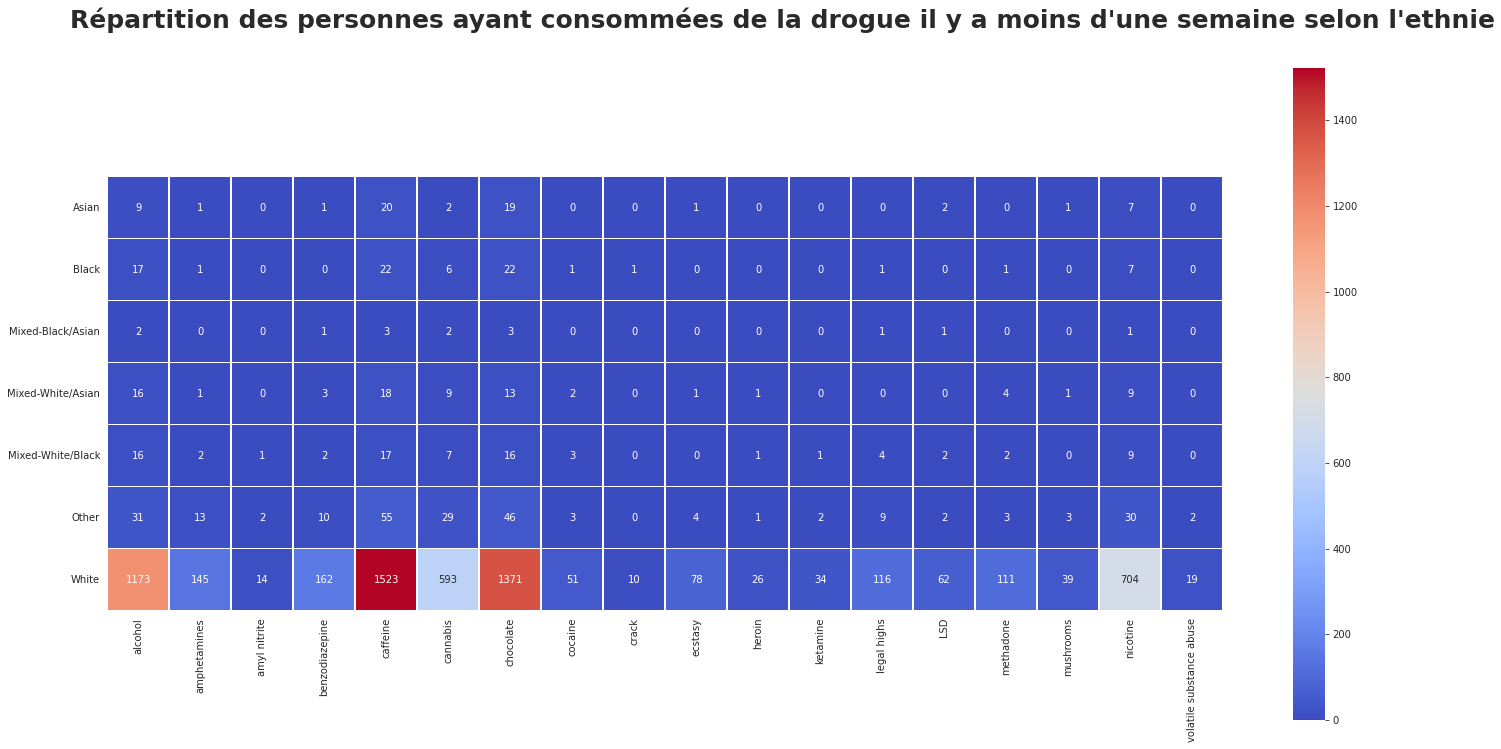

In [ ]:
heatmap(df_analyse, 'Ethnicity', drugs)
plt.suptitle("Répartition des personnes ayant consommées de la drogue il y a moins d'une semaine selon l'ethnie",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

La sur-représentation des personnes blanches est très visible.

**Dans toutes les heatmaps ci-dessus, on constate qu'un grand nombre de cases ont 0 ou très peu de données. Pour notre futur modèle, ce genre de chose peut créer de l'overfitting si on lui demande de faire une prédiction sur un profil qu'il n'a que très peu vu. On va donc chercher à regrouper nos classes ou enlever les personnes appartenant à des classes sous-representées.**

### Graphes de corrélation

Pour mieux visualiser les relations nous allons faire des corrélations heatmaps selon différentes méthodes.

Nous utiliserons toujours la corrélation de Pearson (corrélation linéaire, hypothèse de répartition des données suivant la loi normale). Toutefois, les résultats étaient assez similaire avec la méthode de spearman (car il n'y a pas d'outliers dans nos données).

In [ ]:
def heatmap_corr(dataset, columns1, columns2, method='pearson', mask=False,cmap=None, ready = False):
    fig, ax = plt.subplots(figsize = [24,14])
    if not ready:
      columns = list(set(columns1).union(columns2))
      corr = dataset.loc[:,columns].corr(method=method)
      corr = corr.loc[columns1,columns2]
    else : 
      corr = dataset
    if corr.shape[0] == corr.shape[1] or columns1 == columns2: 
      corr = corr.iloc[1:,:-1]
      columns1 = columns1[1:]
      columns2 = columns2[:-1]
      mask = np.triu(corr, 1)
    vmax = corr.max().max()
    g = sns.heatmap(corr, cmap = cmap
                      , mask=mask, vmax=vmax, center=0, annot=True, square=True, 
                       linewidths=0.5, cbar_kws={'shrink': 0.5})
    g.set_yticklabels(columns1, rotation=0)
    g.set_xticklabels(columns2, rotation=90)

In [ ]:
def cramers_v(crosstab):
    ''' Returns Cramer's V correlation coefficient (and statistic significance) for data 
        delivered as a crosstable. Used for nominal data.
    '''
    
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r,k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return round(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), 3), chi2_contingency(crosstab)[1]

In [ ]:
def nominal_corrs(dataset, col_1_names, col_2_names):
    ''' Returns Cramer's V coefficients matrix and p-value (obtained with Chi-square test of independence) matrix for the whole dataset.
    
    col_1_names, col_2_names - lists of names of columns to correlate. Function creates crosstables for every 
        columns' combination and returns a matrix with single Cramer's V coefficients of every combination;
    pvalues - if set to False, only correlation values will be returned in DataFrame 
        (without '**' marks for significant observations)
    '''
    
    corr_table = pd.DataFrame()
    pval_table = pd.DataFrame()
    for i in range(len(col_1_names)):
        for j in range(len(col_2_names)):
            crosstab = pd.crosstab(dataset[col_1_names[i]], [dataset[col_2_names[j]]])
            corr, pval = cramers_v(crosstab)
            
            v = corr
            
            corr_table.loc[i, j] = v
            pval_table.loc[i,j] = pval
    corr_table.index = col_1_names
    corr_table.columns = col_2_names
    pval_table.index = col_1_names
    pval_table.columns = col_2_names
    
    return corr_table, pval_table

Text(0.5, 0.95, 'Correlations sur la propention à consommer de la drogue plus souvent selon la consommation des autres drogues')

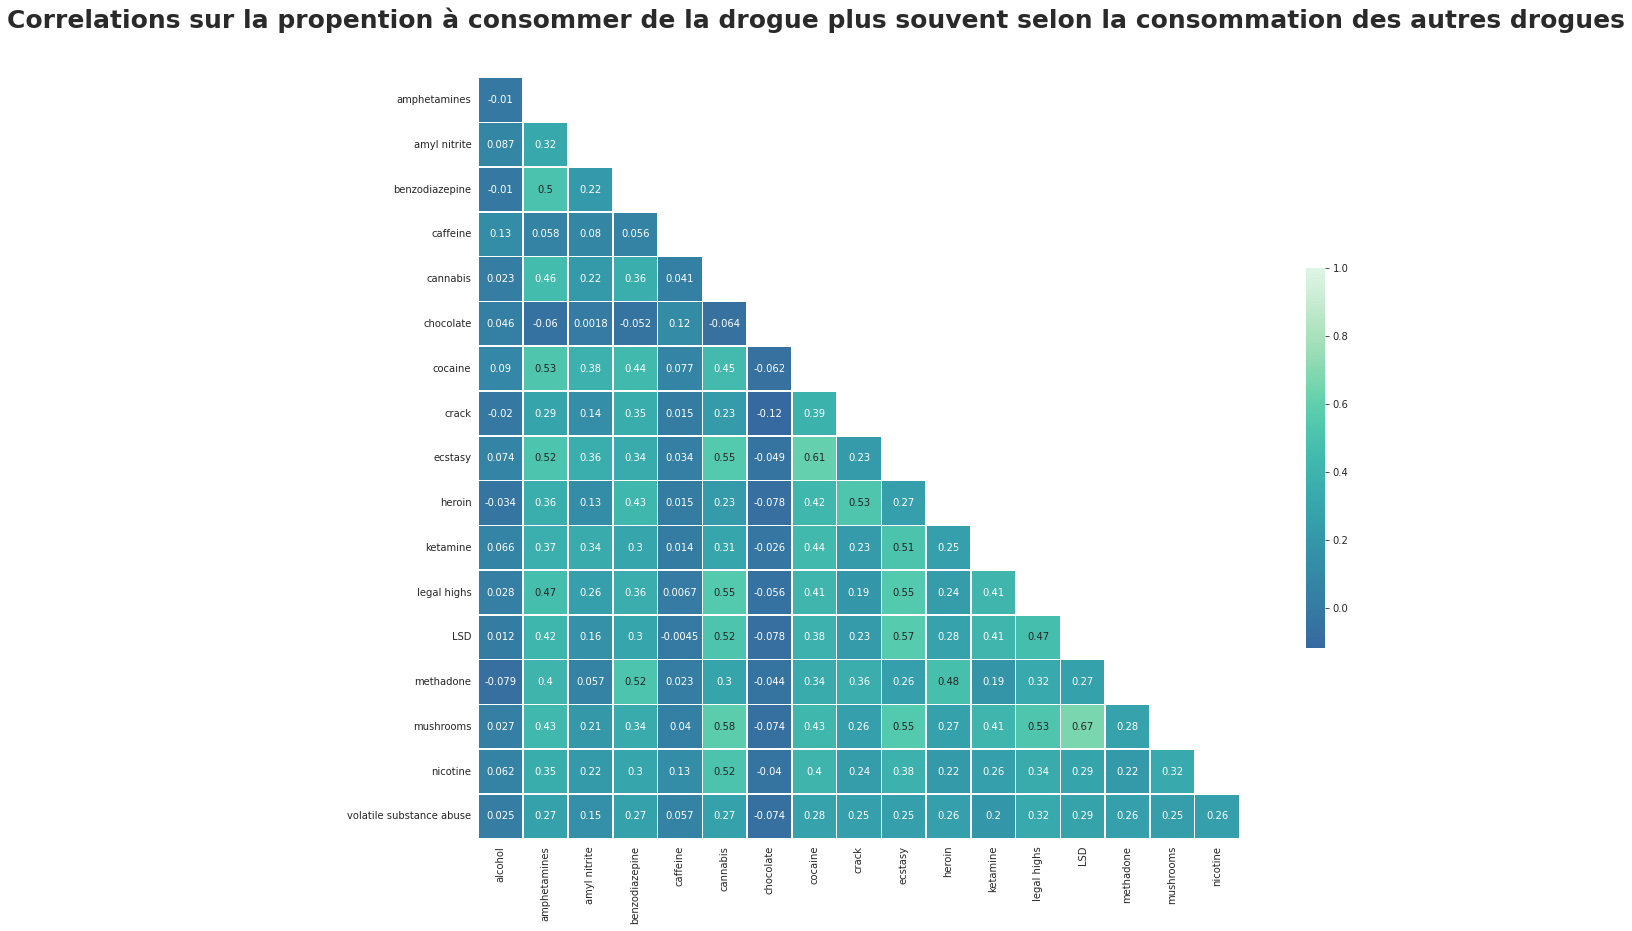

In [ ]:
heatmap_corr(df_analyse, drugs, drugs,cmap=sns.color_palette("mako", as_cmap=True))
plt.suptitle("Correlations sur la propention à consommer de la drogue plus souvent selon la consommation des autres drogues",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

On voit clairement que le chocolat, la caféine et l'alcool n'ont presque pas de corrélation avec les autres drogues (cela n'a donc pas de sens de les inclure dans le même groupe que les autres drogues). Ce qui n'est pas vraiment le cas du cannabis et de la nicotine.

Text(0.5, 0.95, "Correlations sur la propention à consommer de la drogue plus souvent selon la caractère d'un individu")

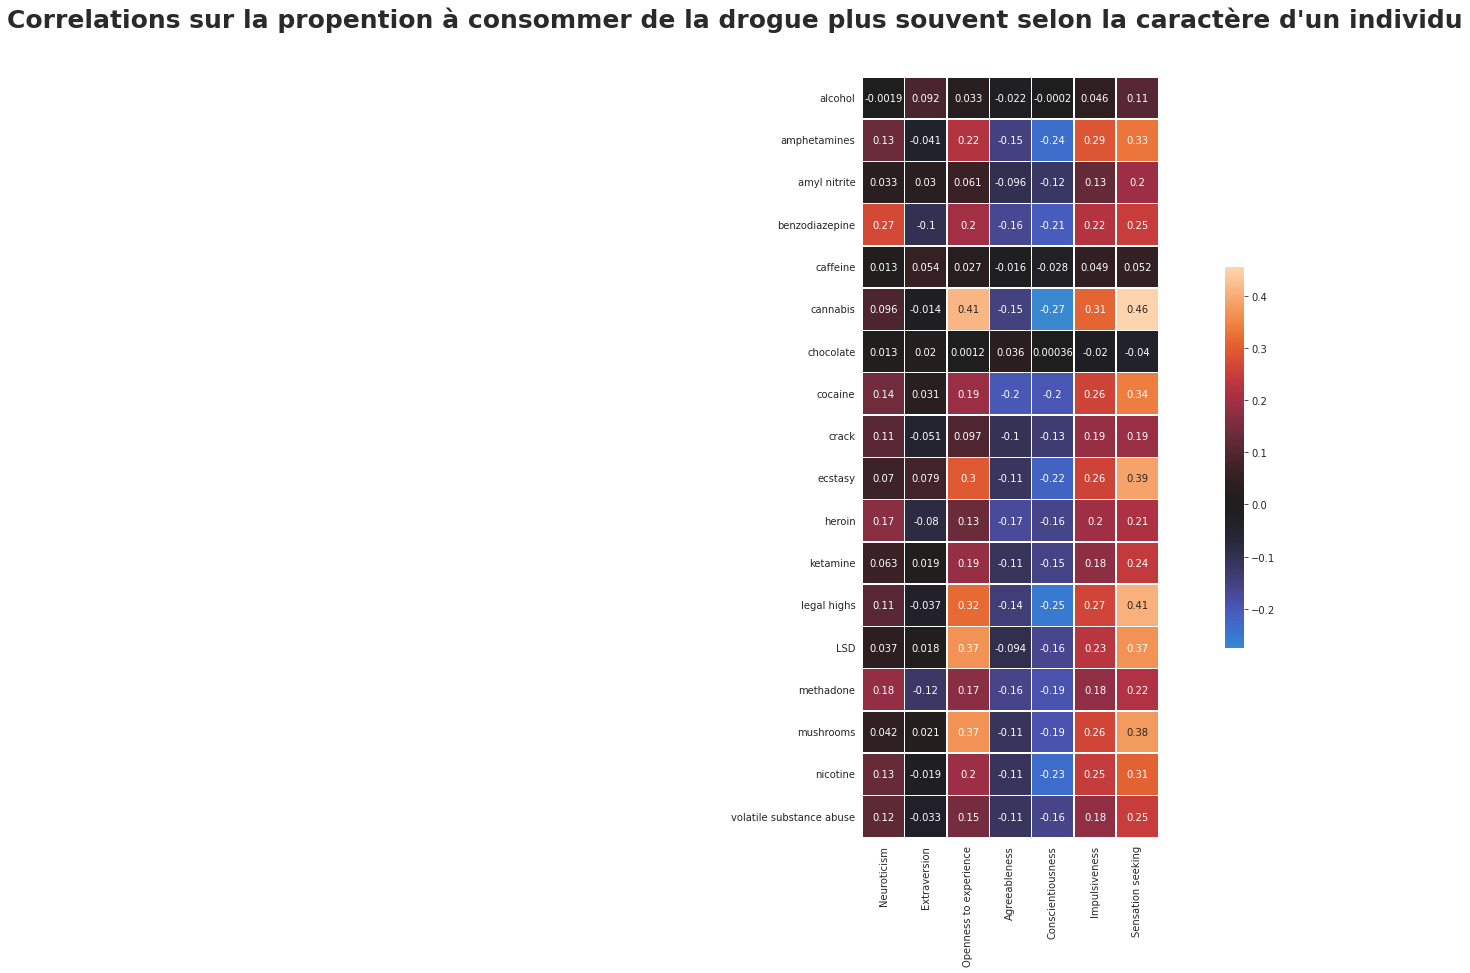

In [ ]:
heatmap_corr(df_analyse, drugs, personality, mask = False)
plt.suptitle("Correlations sur la propention à consommer de la drogue plus souvent selon la caractère d'un individu",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

On trouve encore une fois que la consommation d'alcool, de chocolat et de caféine n'ont pas vraiment de corrélation avec le comportement. La corrélation avec les autres drogues n'est pas très élevée mais reste non négligeable. Le comportement semble être un bon critère discriminant pour notre analyse, surtout la recherche de sensations. La nicotine a des valeurs semblables aux autres drogues, mais elles restent suffisament faibles pour se dire que l'ajout d'une colonne "consomation de nicotine" dans le dataset pour prédire la target reste pertinent.

<class 'pandas.core.frame.DataFrame'>


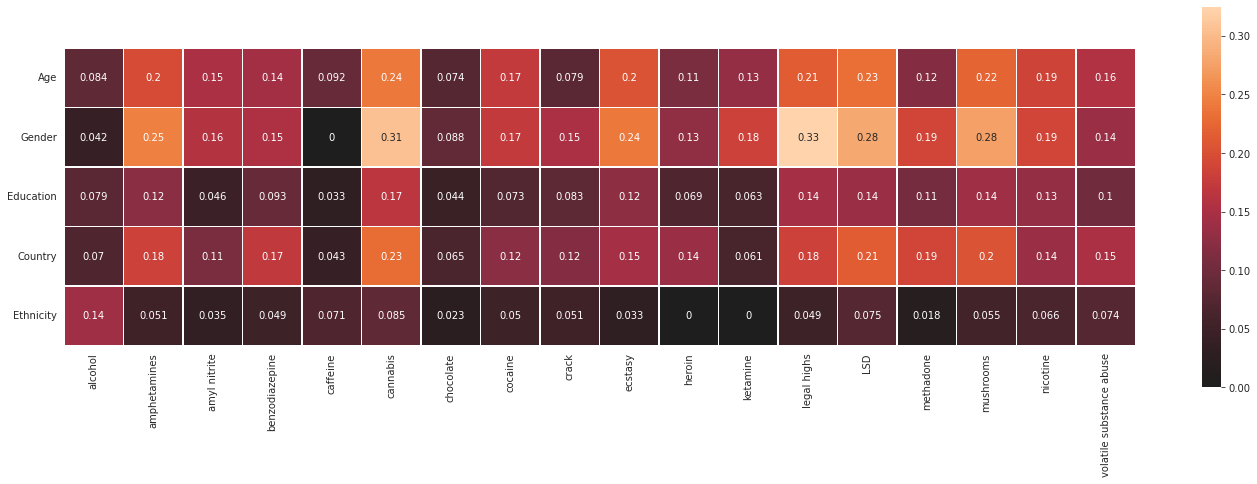

In [ ]:
table, osef = nominal_corrs(df_analyse,perso, drugs)
print(type(table))
heatmap_corr(table, perso, drugs, ready=True)
#plt.suptitle("Correlations sur la propention à consommer de la drogue plus souvent selon la caractère d'un individu",fontsize=25,weight = 'bold',c="#2A2A2A", y=0.95)

La corrélation entre l'ethnie/l'éducation et la consommation de drogue est très faible. 

## Prédiction des profils plus disposés à consommer souvent des drogues avec du machine learning

### Définition de la target et pré-processing 

#### Préparation de la target et modification des données

Au vu de l'analyse que nous avons faite précédemment, nous allons modifier quelque peu notre dataset: 

 Pour la création de notre target, nous n'allons pas prendre en compte les consommations de chocolat, de caféine, de nicotine et d'alcool. Nous allons aussi enlever le cannabis à cause de sa sur-représentation parmi les autres drogues non citées ci-dessus (si on ne l'avait pas enlevée, notre modèle aurait un gros biais et ferait essentiellement de la prédiction de consommation de cannabis). La consommation de nicotine sera une des datas qui nous permettera de prédire la target.

Pour les autres variables, nous allons regrouper certaines classes pour éviter les problèmes d'overfitting à cause du peu de donnée.

- Pour l'âge, nous allons regrouper les 65+ avec les 55-64 (groupe de personnes similaires)
- Pour l'éducation, nous allons  regrouper toute les personnes ayant arrêté l'école avant 18 ans (groupe de personnes similaires aussi)
- Nous allons enlever la classe "autres" pour les pays (manque de précision). Nous allons regrouper l'Australie et la Nouvelle-Zélande ainsi que le Royaume-Uni et l'Irlande (à priori assez similaires)
- Nous allons enlever la colonne ethnie (corrélation linéaire faible avec la consommation de drogue, sur-représentation des blancs et potentiel problème moral lié au fait de se servir de l'éthnie comme d'un critère discriminant).



In [18]:
df_model=df_analyse.copy()

drugs_not_target = ['alcohol', 'caffeine', 'chocolate', 'nicotine',"cannabis"]

drugs_target = [drug for drug in drugs if drug not in drugs_not_target]
drugs_target 


targets=[]
for i in range(len(df_model)):
  target=0
  for col in drugs_target:
    if df_model.loc[i,col] in [5,6]:
      target=1
  targets.append(target)

df_model["target"]=targets

df_model=df_model.drop(drugs_target+['alcohol', 'caffeine', 'chocolate',"cannabis"],axis=1)

df_model=df_model.drop("Ethnicity",axis=1)

df_model.loc[df_model["Age"]=="65+","Age"]='55-64'
df_model.loc[df_model["Age"]=='55-64',"Age"]='55+'


df_model["Education"]=df_model["Education"].map({"Left school before 16 years":"Left school before 18 years",
                                                     "Left school at 16 years":"Left school before 18 years",
                                                    "Left school at 17 years":"Left school before 18 years",
                                                      "Left school at 18 years":"Left school before 18 years",
                                                      "Some college or university, no certificate or degree":"Some college or university, no certificate or degree",
                                                      "Professional certificate/ diploma": "Professional certificate/ diploma",
                                                      "University degree":"University degree",
                                                     "Masters degree":"Masters degree", 
                                                     "Doctorate degree":"Doctorate degree"  })


df_model["Country"]=df_model["Country"].map({"Australia": "Australia+NZ",
                                                 "Canada": "Canada",
                                                 "New Zealand": "Australia+NZ",
                                                 "Other": "Other",
                                                 "Republic of Ireland": "UK+Ireland",
                                                 "UK":"UK+Ireland",
                                                 "USA": "USA" })



df_model=df_model.drop(df_model[df_model["Country"]=="Other"].index,axis=0)

In [21]:
df_model.shape

(1767, 13)

In [ ]:
df_model["Age"].value_counts()

18-24    592
25-34    442
35-44    339
45-54    285
55+      109
Name: Age, dtype: int64

In [ ]:
df_model["Country"].value_counts()

UK+Ireland      1064
USA              557
Canada            87
Australia+NZ      59
Name: Country, dtype: int64

In [ ]:
df_model["Education"].value_counts()

University degree                                       464
Some college or university, no certificate or degree    457
Masters degree                                          263
Professional certificate/ diploma                       256
Left school before 18 years                             242
Doctorate degree                                         85
Name: Education, dtype: int64

In [ ]:
df_model["target"].value_counts()

0    1263
1     504
Name: target, dtype: int64

On se retrouve avec une target assez équilibrée et avec un nombre assez acceptable de représentants dans les deux classes.

#### Encoding et Normalisation

In [ ]:
y=df_model["target"].reset_index(drop=True)
X=df_model.drop("target",axis=1).reset_index(drop=True)

Comme nous avons modifié les classes des colonnes dans une partie de nos données, nous ne pouvons pas garder les valeurs de normalisation initiales du dataset. Nous allons donc renormaliser et réenconder les variables concernées.

In [ ]:
encoder=OneHotEncoder()

names_column=["is_Australia_NZ","is_Canada","is_UK_Ireland","is_USA"]
onehot=pd.DataFrame(encoder.fit_transform(X[["Country"]]).toarray()).set_axis(names_column,axis=1)
onehot
X=pd.concat([X.drop(["Country"],axis=1),onehot],axis=1)

maplist = [{'col': "Education", 'mapping': {'Left school before 18 years': 0, 'Some college or university, no certificate or degree': 1,'Professional certificate/ diploma': 2,"University degree":3  , 'Masters degree': 4, 'Doctorate degree': 5}}]
encoder_ordinal=OrdinalEncoder(mapping=maplist)
names_column2=["Education"]
ordinal=pd.DataFrame(encoder_ordinal.fit_transform(X[["Education"]])).set_axis(names_column2,axis=1)
X=pd.concat([X.drop(["Education"],axis=1),ordinal],axis=1)

skencoder_ordinal=skOrdinalEncoder()
names_column21=["Age","Gender"]
ordinal1=pd.DataFrame(skencoder_ordinal.fit_transform(X[["Age","Gender"]])).set_axis(names_column21,axis=1)
X=pd.concat([X.drop(["Age","Gender"],axis=1),ordinal1],axis=1)

scaler = RobustScaler()
names_column3=["Age","Education","nicotine"]
standard=standard=pd.DataFrame(scaler.fit_transform(X[["Age","Education","nicotine"]])).set_axis(names_column3, axis=1)
X=pd.concat([X.drop(["Age","Education","nicotine"],axis=1),standard],axis=1)
X

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking,is_Australia_NZ,is_Canada,is_UK_Ireland,is_USA,Gender,Age,Education,nicotine
0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0.0,0.0,1.0,0.0,0.0,0.5,0.0,-0.2
1,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,0.0,0.0,1.0,0.0,1.0,0.0,1.5,0.2
2,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0.0,0.0,1.0,0.0,1.0,0.5,0.0,-0.6
3,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0.0,0.0,1.0,0.0,0.0,-0.5,1.0,-0.2
4,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0.0,0.0,1.0,0.0,0.0,0.5,1.5,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,0.0,0.0,0.0,1.0,0.0,-0.5,-0.5,-0.6
1763,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,0.0,0.0,0.0,1.0,1.0,-0.5,-0.5,0.4
1764,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.6
1765,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,0.0,0.0,0.0,1.0,0.0,-0.5,-0.5,0.2


### Création et comparaison des modèles

Nous allons considérer que nous travaillons pour une association ou un organisme d'assistance sociale qui souhaite anticiper si une personne a plus ou moins de chance de devenir consommateur régulier de drogue. Nous allons résoudre ce problème en développant un modèle de prédiction.

Dans ce cadre, nous considérons qu'il est plus grave que le modèle considère qu'une personne ne va pas se tourner vers la drogue alors que c'est le cas (faux négatif), que le cas inverse où l'algorithme est trop prudent et considère qu'une personne "safe" risque de se tourner vers la drogue (faux négatif). Nous allons viser 80% de recall, c'est à dire que le modèle classe  au moins 80% des vraies potentiels toxicomanes en tant que tels, et n'en oublie que 20%. Le but sera donc de limiter au maximum les conséquences sur la précision du modèle (c'est à dire limiter le nombre de personnes considérées comme toxicomane alors qu'elles sont "safe").

Nous allons d'abord tester six modèles sans apporter de tuning et en les évaluant avec une courbe ROC et une matrice de confusion, puis nous apporterons du tuning. Nous examinerons enfin le compromis entre recall et précision.

#### Définition des fonctions et splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [ ]:
def test_model(modele,X_train,X_test,y_train,y_test,i=None,ax=None):#entraîne le modèle et affiche une matrice de confusion et une courbe ROC

    modele.fit(X_train,y_train)
    plot_confusion_matrix(modele,X_test,y_test,ax=ax[i,0],cmap=plt.cm.Reds)
    ax[i,0].grid(False)
    plot_roc_curve(modele,X_test,y_test,ax=ax[i,1])
    ax[i,1].grid(True)
   

def métriques(predictions,y_test):#affiche le recall, la précision et le f1 score du modèle
    print('f1 score=',f1_score(y_test,predictions))
    print('precision=',precision_score(y_test,predictions))
    print('recall=',recall_score(y_test,predictions))

#### Evaluation des modèles sans tuning

In [ ]:
#modèle simple
svc=SVC(random_state=0)
voisins=KNeighborsClassifier()
logistique=LogisticRegression(random_state=0)

#modèles ensemblistes
ADAboost=AdaBoostClassifier(random_state=0)
randomforest = RandomForestClassifier(random_state=0)
xgb=XGBClassifier(random_state=0)

models=[svc,voisins,logistique,ADAboost,randomforest,xgb]
models_string=["svc","voisins","logistique","ADAboost","randomforest","xgboost"]

On teste 3 modèles simples et 3 modèles plus complexes. L'intérêt est de voir si un modèle complexe apporte réellement une plus-value à l'estimation. Si ce n'est pas le cas, on va préférer un modèle simple pour éviter les potentiels problèmes d'overfitting.

On va d'abord directement tester nos modèles sur le testset:

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

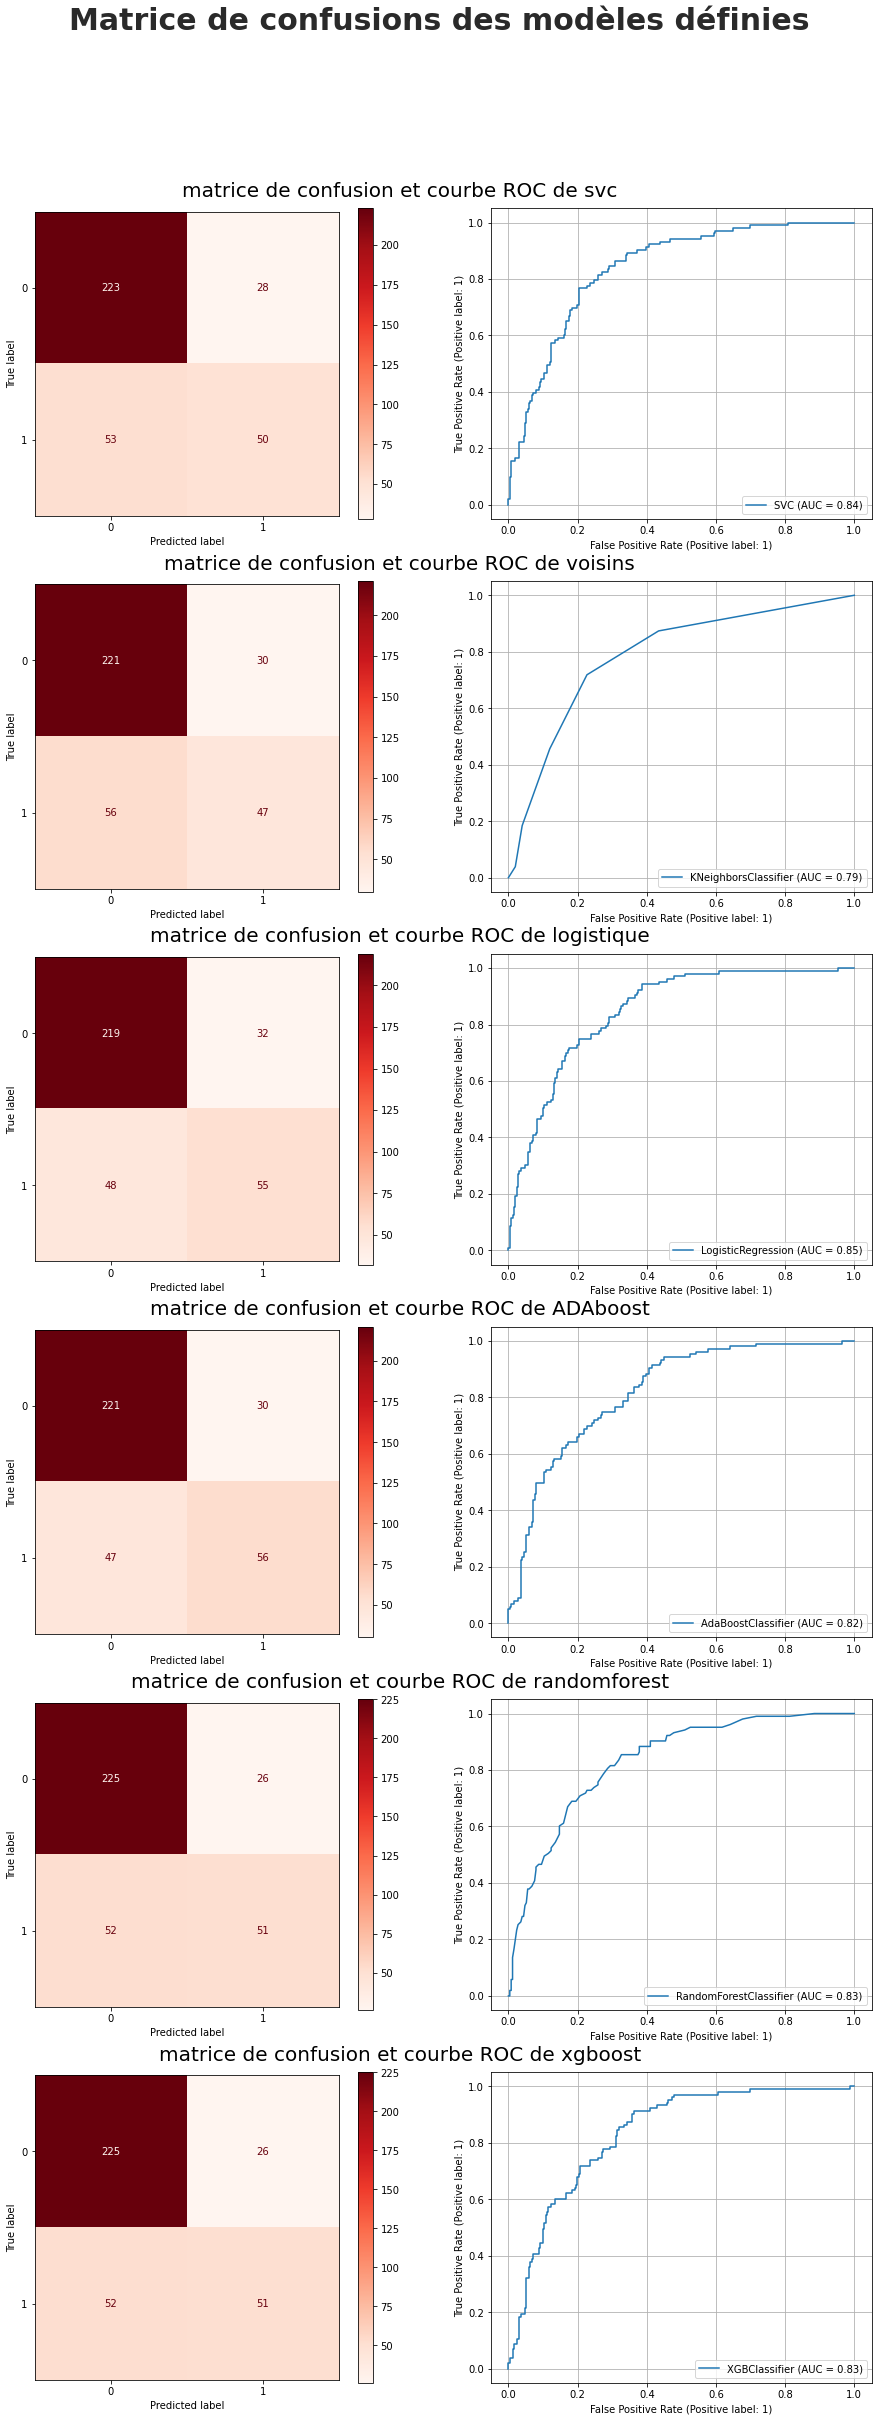

In [ ]:
fig,ax=plt.subplots(6,2,figsize=(15,40))
plt.suptitle("Matrice de confusions des modèles définies",fontsize=30, x=0.5, y=0.95, weight = 'bold',c="#2A2A2A")
for model,i in zip(models,range(6)):
  test_model(model,X_train,X_test,y_train,y_test,i,ax)
  ax[i,0].set_title(f"matrice de confusion et courbe ROC de {models_string[i]}",fontsize=20,x=1.2,y=1.03)
plt.savefig('ROC 1.png', bbox_inches='tight')

In [ ]:
for model,model_string in zip(models,models_string):
  predictions=model.predict(X_test)
  print(f"Scores obtenus avec le modèle {model_string}\n")
  métriques(predictions,y_test)
  print("\n\n")

Scores obtenus avec le modèle svc

f1 score= 0.5524861878453039
precision= 0.6410256410256411
recall= 0.4854368932038835



Scores obtenus avec le modèle voisins

f1 score= 0.5222222222222223
precision= 0.6103896103896104
recall= 0.4563106796116505



Scores obtenus avec le modèle logistique

f1 score= 0.5789473684210527
precision= 0.632183908045977
recall= 0.5339805825242718



Scores obtenus avec le modèle ADAboost

f1 score= 0.5925925925925926
precision= 0.6511627906976745
recall= 0.5436893203883495



Scores obtenus avec le modèle randomforest

f1 score= 0.5666666666666668
precision= 0.6623376623376623
recall= 0.49514563106796117



Scores obtenus avec le modèle xgboost

f1 score= 0.5666666666666668
precision= 0.6623376623376623
recall= 0.49514563106796117





Tous les modèles testés ont des résultats assez similaires. On constate qu'ils ont du mal à prédire correctement les vraies positifs (recall faible). La courbe ROC indique que chaque modèle peut espérer environ 80% de vrais positifs (recall=80%) au prix de 30% sur le taux de faux positifs environ (plutôt 25% pour SVC).

#### Tuning des modèles

**Random state non défini: les résultats peuvent changer apres execution**

On modifie les hyperparamètres du modèle pour améliorer le modèle. On passe par une cross-validation sur les données d'entrainement pour limiter l'overfitting. On utilise le score ROC_AUC pour évaluer les configurations possibles de chaques modèles.

In [ ]:
svc_tun=SVC(random_state=0)
voisins_tun=KNeighborsClassifier()
logistique_tun=LogisticRegression(random_state=0)
ADAboost_tun=AdaBoostClassifier(random_state=0)
randomforest_tun = RandomForestClassifier(random_state=0)
xgb_tun=XGBClassifier(random_state=0)

parameters_svc = {'kernel':("linear", "poly", "rbf"), 'C':np.arange(1,15,2)}
parameters_voisins = {'n_neighbors':np.arange(2,10,3), 'p':np.arange(1,9,1),"leaf_size":np.arange(10,51,10)}
parameters_logistique = {"penalty":["l1", "l2", "elasticnet"],"C":np.arange(1.0,10.0,2.0),"solver":["lbfgs","saga"],"l1_ratio":[0.5,0.5,0.75]}
parameters_ADAboost = {"n_estimators":[10,20,50,100,250], "learning_rate":[0.01,0.1,1,10]}
parameters_randomforest = {"n_estimators":[20,50,100,200,500],"max_depth":[1,2,3,5],"min_samples_split":[2,3,5]}
parameters_xgb = {'max_depth':range(3,10,2),'min_child_weight':range(1,8,2),'gamma':[i/10.0 for i in range(0,5)]}

models_tun=[svc_tun,voisins_tun,logistique_tun,ADAboost_tun,randomforest_tun,xgb_tun]
models_string_tun=["svc","voisins","logistique","ADAboost","randomforest","xgboost"]
parameters=[parameters_svc,parameters_voisins,parameters_logistique,parameters_ADAboost,parameters_randomforest,parameters_xgb]


In [ ]:
for model,i in zip(models_tun,range(6)):
  grid = GridSearchCV(model, parameters[i],scoring='roc_auc',cv=5)
  grid.fit(X_train,y_train)
  print(f"{models_string_tun[i]}:\n best params:{grid.best_params_}\n best ROC_AUC score:{ grid.best_score_}\n\n ")


svc:
 best params:{'C': 5, 'kernel': 'linear'}
 best ROC_AUC score:0.8238682001068197

 
voisins:
 best params:{'leaf_size': 10, 'n_neighbors': 8, 'p': 1}
 best ROC_AUC score:0.774394171012613

 


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/

logistique:
 best params:{'C': 1.0, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}
 best ROC_AUC score:0.8285485344511463

 
ADAboost:
 best params:{'learning_rate': 0.1, 'n_estimators': 50}
 best ROC_AUC score:0.8295099471290861

 
randomforest:
 best params:{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
 best ROC_AUC score:0.8321500203523362

 
xgboost:
 best params:{'gamma': 0.4, 'max_depth': 3, 'min_child_weight': 3}
 best ROC_AUC score:0.8181594804253278

 


Le pavé de texte dans l'output est généré par la régression logistique, qui explique qu'elle n'accepte pas toutes les configurations de pénalisation possibles selon la valeur de solver. 

La meilleure configuration possible pour le KNN ressemble à de l'overfitting (k_neighbors=8 --> élevé donc risque d'overfitting). Elle affiche aussi un score ROC_AUC légèrement en dessous des autres modèles.

La random forest à aussi des valeurs élevées qui sous-entendent un risque d'overfitting, mais le fait d'avoir un grand nombre d'estimateurs dans la forêt fait "lisser" l'overfiting.


#### Evaluation avec tuning

On teste maintenant les configurations sélectionnées sur notre testset

In [ ]:
svc_tunné=SVC(C= 3, kernel= 'linear',random_state=0,probability=True)
voisins_tunné=KNeighborsClassifier(leaf_size= 10, n_neighbors= 8, p= 2)
logistique_tunné=LogisticRegression(C= 1.0, l1_ratio=0.75, penalty= 'elasticnet', solver= 'saga',random_state=0)
ADAboost_tunné=AdaBoostClassifier(learning_rate= 0.1,n_estimators= 50,random_state=0)
randomforest_tunné = RandomForestClassifier(max_depth= 5,min_samples_split= 5,n_estimators=200,random_state=0)
xgb_tunné=XGBClassifier(gamma= 0.4, max_depth= 3, min_child_weight= 3,random_state=0)

models_tunné=[svc_tunné,voisins_tunné,logistique_tunné,ADAboost_tunné,randomforest_tunné,xgb_tunné]
models_string_tunné=["svc tunné","voisins tunné","logistique tunné","ADAboost tunné","randomforest tunné","xgboost tunné"]




/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

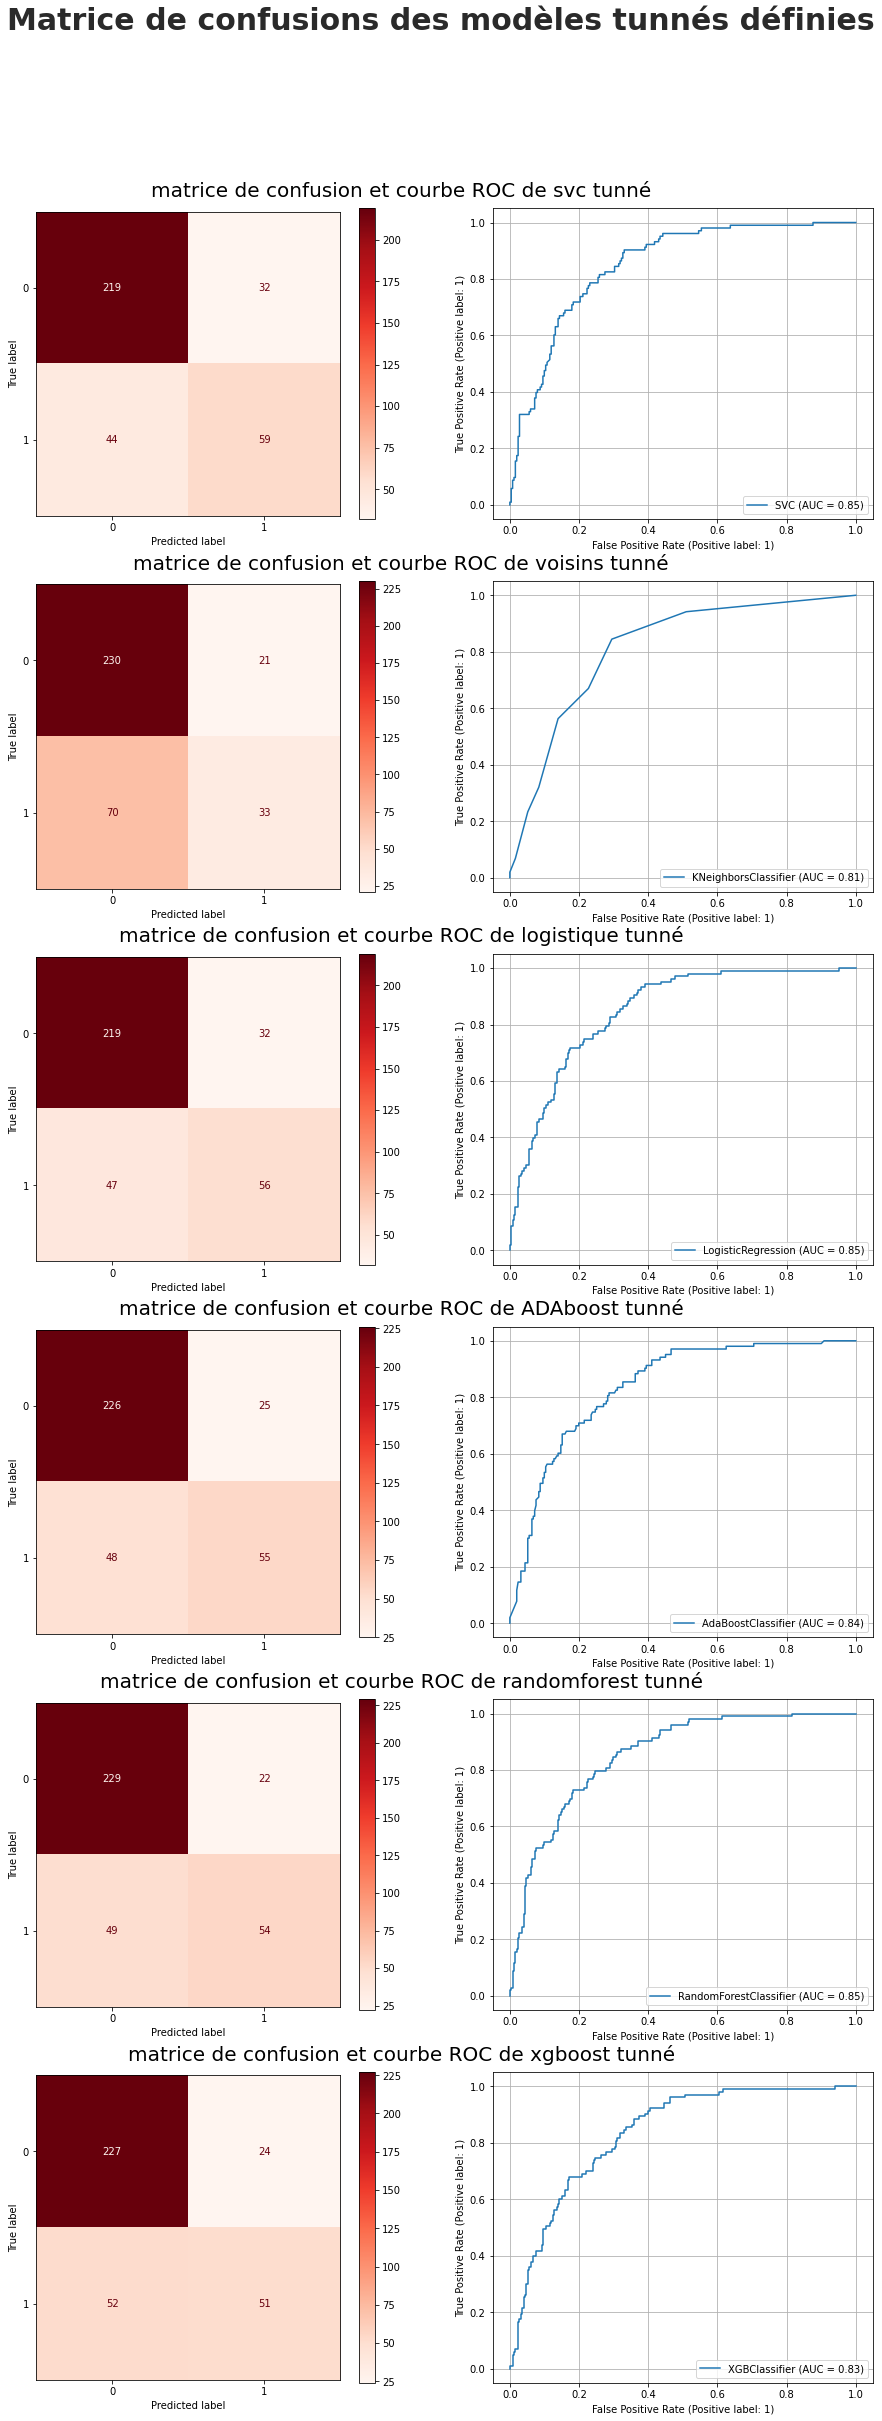

In [ ]:
fig,ax=plt.subplots(6,2,figsize=(15,40))
plt.suptitle("Matrice de confusions des modèles tunnés définies",fontsize=30, x=0.5, y=0.95, weight = 'bold',c="#2A2A2A")
for model_tunné,i in zip(models_tunné,range(6)):
  test_model(model_tunné,X_train,X_test,y_train,y_test,i,ax)
  ax[i,0].set_title(f"matrice de confusion et courbe ROC de {models_string_tunné[i]}",fontsize=20,x=1.2,y=1.03)
plt.savefig('ROC 2.png', bbox_inches='tight')

In [ ]:
for model_tunné,model_string_tunné in zip(models_tunné,models_string_tunné):
  predictions=model_tunné.predict(X_test)
  print(f"Scores obtenus avec le modèle {model_string_tunné}\n")
  métriques(predictions,y_test)
  print("\n\n")

Scores obtenus avec le modèle svc tunné

f1 score= 0.6082474226804123
precision= 0.6483516483516484
recall= 0.5728155339805825



Scores obtenus avec le modèle voisins tunné

f1 score= 0.42038216560509556
precision= 0.6111111111111112
recall= 0.32038834951456313



Scores obtenus avec le modèle logistique tunné

f1 score= 0.5863874345549738
precision= 0.6363636363636364
recall= 0.5436893203883495



Scores obtenus avec le modèle ADAboost tunné

f1 score= 0.6010928961748634
precision= 0.6875
recall= 0.5339805825242718



Scores obtenus avec le modèle randomforest tunné

f1 score= 0.6033519553072626
precision= 0.7105263157894737
recall= 0.5242718446601942



Scores obtenus avec le modèle xgboost tunné

f1 score= 0.5730337078651686
precision= 0.68
recall= 0.49514563106796117





Les modèles tunés sont légèrement meilleurs que les non-tunés quand on regarde les scores (sauf pour le KNN, qui s'empire à cause de l'overfitting).

En regardant les courbes ROC, on peut voir qu'on arrive à atteindre un recall de 80%  au prix d'un taux de faux positifs d'environ 25% avec les modèles SVC et random forest. Nous allons considérer que ce sont les deux meilleurs modèles pour notre problème.

On va maintenant changer le compromis précision/recall pour les deux modèles. 

#### Compromis recall/précision et conclusions

Nous allons récuperer les probabilités associées à chaque prédictions par le modèle et modifier le seuil de décision (à la base, le modèle calcule une probabilité et renvoie la valeur 1 si la proba est supérieur à 50% et 0 sinon).

Le but étant d'indiquer à l'utilisateur quelle est le meilleur seuil de probabilité pour avoir 80% de vrais positifs. Nous allons ensuite comparer les deux modèles pour voir lequel des deux offre la meilleure précision sur ce seuil.

On va tracer une courbe de précision et de rappel pour les deux courbes et trouver la précision et la valeur de seuil associée aux 80% de recall pour les deux modèles.

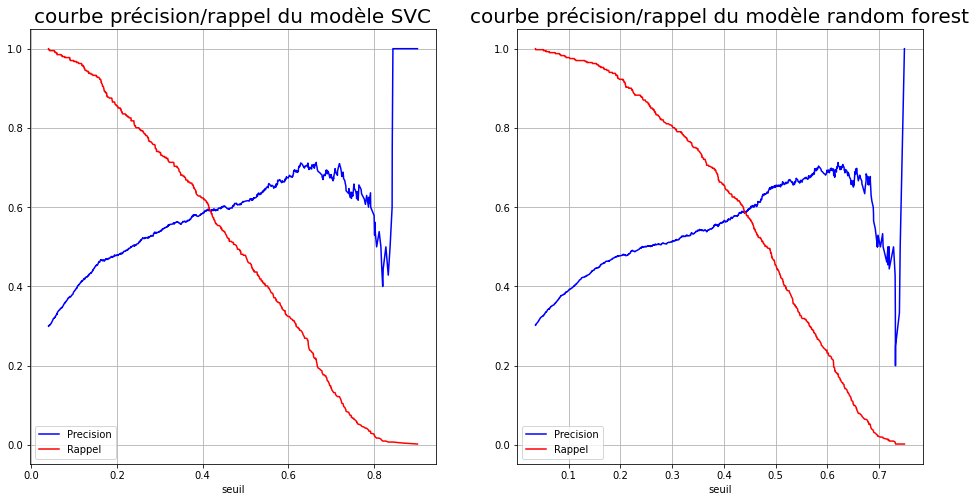

In [ ]:
# On fait une validation croisé sur le testset pour recuperer le svaleurs de probabilités
y_scores_svc=cross_val_predict(svc_tunné,X_train,y_train,cv=5,method="predict_proba")
y_scores_rf=cross_val_predict(randomforest_tunné,X_train,y_train,cv=5,method="predict_proba")
precisions_svc,recalls_svc,seuils_svc=precision_recall_curve(y_train,y_scores_svc[:,1])
precisions_rf,recalls_rf,seuils_rf=precision_recall_curve(y_train,y_scores_rf[:,1])


fig,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(seuils_svc,precisions_svc[:-1],'b',label="Precision")
ax[0].plot(seuils_svc,recalls_svc[:-1],"r",label="Rappel")
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel('seuil')
ax[0].set_title("courbe précision/rappel du modèle SVC",fontsize=20)

ax[1].plot(seuils_rf,precisions_rf[:-1],'b',label="Precision")
ax[1].plot(seuils_rf,recalls_rf[:-1],"r",label="Rappel")
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel('seuil')
ax[1].set_title("courbe précision/rappel du modèle random forest",fontsize=20)
plt.savefig('ROC 3.png', bbox_inches='tight')

La précision devient assez chaotique quand le seuil de probabilité augmente (ce n'est pas un comportement anormal, mais on ne peut pas vraiment faire confiance à cette partie de la courbe quand on sera sur notre testset, on ne touchera pas à des valeurs de seuil supérieures à 0.5 de toutes façons)

In [ ]:
print(f"précision  à 80% de recall pour random forest: {precisions_rf[np.where(recalls_rf==max(recalls_rf[recalls_rf<0.8]))[0][-1]]}, seuil de proba associé:{seuils_rf[np.where(recalls_rf==max(recalls_rf[recalls_rf<0.8]))[0][-1]]}")
print(f"précision  à 80% de recall pour SVC: {precisions_svc[np.where(recalls_rf==max(recalls_svc[recalls_svc<0.8]))[0][-1]]}, seuil de proba associé:{seuils_svc[np.where(recalls_rf==max(recalls_svc[recalls_svc<0.8]))[0][-1]]}")


précision  à 80% de recall pour random forest: 0.5169628432956381, seuil de proba associé:0.3067221880920487
précision  à 80% de recall pour SVC: 0.508716323296355, seuil de proba associé:0.24973200779854532


La random forest a une précision légerement meilleure à 80% de recall, mais on reste essentiellement dans la marge d'erreur.

Si on applique les seuils de probabilité sur le testset, on obtient les résultats suivants: 

SVC: 

f1 score= 0.6640316205533596
precision= 0.56
recall= 0.8155339805825242

RandomForest: 

f1 score= 0.6533864541832669
precision= 0.5540540540540541
recall= 0.7961165048543689


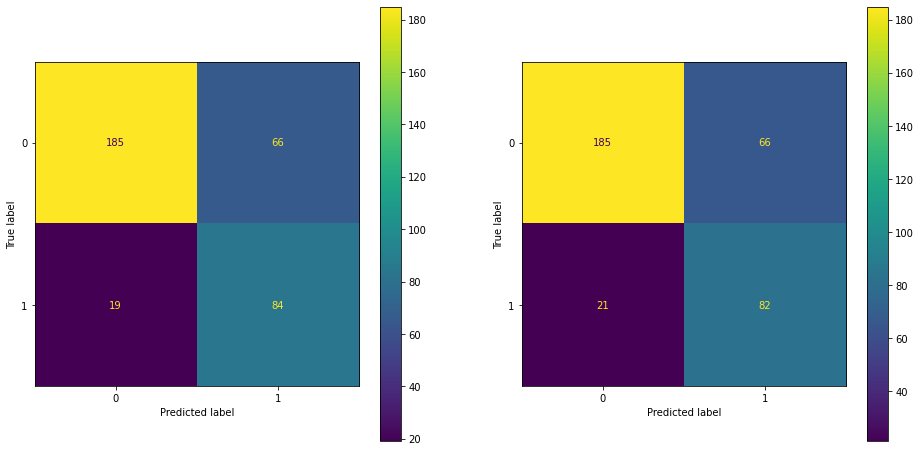

In [ ]:
results_svc=svc_tunné.predict_proba(X_test)
seuil_svc=0.23
result_réajusté_svc=(results_svc[:,1]>seuil_svc)


results_rf=randomforest_tunné.predict_proba(X_test)
seuil_rf=0.3
result_réajusté_rf=(results_rf[:,1]>seuil_rf)



fig,ax=plt.subplots(1,2,figsize=(16,8))

matrice_svc=confusion_matrix(y_test,result_réajusté_svc)
ConfusionMatrixDisplay(confusion_matrix=matrice_svc).plot(ax=ax[0])

matrice_rf=confusion_matrix(y_test,result_réajusté_rf)
ConfusionMatrixDisplay(confusion_matrix=matrice_rf).plot(ax=ax[1])

print("SVC: \n")
métriques(result_réajusté_svc,y_test)
print("\nRandomForest: \n")
métriques(result_réajusté_rf,y_test)
plt.savefig('ROC 4.png')

Le SVC a une précision et un rappel légèrement plus élevés que le random forest sur le testset. Cela confirme que les deux sont assez proches.



**Conclusion: le modele SVC tuné et random forest tuné sont les meilleurs parmis ceux testés pour prédire avec un recall de 80% les personnes qui sont toximanes ou qui risquent de le devenir. Les deux modèles obtiennent une précision d'environ 55%. Le SVC est plus rapide à executer mais le random forest peut encore être améliorer si on augmente le nombre d'arbres**


**Concrètement, l'utilisateur du modèle peut espérer que 80% de personnes réellement "toxicomanes" soient prédites correctement si on assume que 45% des personnes prédites comme "toxicomanes" ne le sont en fait pas. Il faut pour cela que les seuils des probabilités soient de 23% (SVM) et 30% (RandomForest).**

**Toutefois l'utilisateur reste libre de se fier à son jugement, en choisissant comment classifier une personne en regardant les probabilités prédites par le modèle.**